In [128]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from evaluation_functions import ensemble_evaluation_functions as eef
import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
from calibration_functions import huxt_rank_functions as hrf

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number
import astropy.units as u

from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

In [2]:
def read_deterministic_forecast_cdf(cr):
    ### Reads in deterministic forecast runs
    input_file = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\deterministic_forecasts\\deterministic_CR{cr}.nc'

    # Read the NetCDF file into an xarray Dataset
    loaded_ds = xr.open_dataset(input_file)

    df = loaded_ds.sel().to_dataframe()

    return df

def compute_roc_score(roc_curve):
    """
    Computes integrates area under ROC curve using scipy quad returning integrated area as the ROC score

    Parameters:
    - roc_curve (list): list of tuples which each contain the hit rate and false alarm rate calculated at different thresholds

    Returns:
    - result (float): ROC Score calculated as the integrated area under ROC curve
    """

    # Unpack and prepare roc curve data
    y,x = zip(*roc_curve)

    x = np.array([xx for xx in x])
    y = np.array([yy for yy in y])

    nan_mask_x = ~np.isnan(x)
    nan_mask_y = ~np.isnan(y)

    nan_mask = np.logical_and(nan_mask_x, nan_mask_y)

    x = x[nan_mask]
    y = y[nan_mask]

    # Interpolate the curve
    interp_function = scipy.interpolate.interp1d(x, y, kind='linear')

    # Define the integration limits
    a = min(x)
    b = max(x)

    # Perform the integration
    result, error = integrate.quad(interp_function, a, b)

    return result


def interpolate_and_resample(observed_data_index, forecast_index, forecast):
    
    # This function runs an interpolation algorithm on forecast output and outputs a resamples forecast series on the omni data timestep
    Int = scipy.interpolate.CubicSpline(forecast_index, forecast)

    interpolated_forecast_output = Int(observed_data_index)

    return interpolated_forecast_output


def perturb_longitude(long_pert_dt, ensemble_member):
    
    # Ensure that the DataFrame has a datetime index
    if not isinstance(ensemble_member.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a datetime index")
    
    shift_amount = int(long_pert_dt.to(u.second).value) # Convert shift amount into seconds

    # Convert datetime index into integers
    numeric_index = ensemble_member.index.astype(int) // 10**9 # Floor division to convert into seconds (UNIX int datetime is in nanoseconds)
    numeric_index = numeric_index.to_numpy()

    # Calculate the new index by shifting with wrapping
    shifted_index = numeric_index + shift_amount

    # Generate boolean array which captures elements above and below max/min indices
    wrap_mask = (shifted_index < numeric_index.min()) | (shifted_index > numeric_index.max())
  
    if shift_amount < 0:
        # If negative shift amount (i.e. elements will be below min index)
        shifted_index[wrap_mask] = shifted_index[wrap_mask] + (shifted_index.max() - shifted_index.min())

    elif shift_amount > 0:
        # If positive shift amount (i.e. elements will be above max index)  
        shifted_index[wrap_mask] = shifted_index[wrap_mask] - (shifted_index.max() - shifted_index.min())

    else:
        # No change -- preserve original index
        shifted_index = numeric_index

    # Convert back to datetime index
    new_converted_index = pd.to_datetime(shifted_index, unit='s')

    # Sort the DataFrame based on the new index
    df_shifted = ensemble_member.copy()
    df_shifted = (df_shifted.sort_index().set_index(new_converted_index)).sort_index()
    df_shifted = df_shifted[~(df_shifted.index).duplicated()].copy()

    # Interpolate shifted dataframe back onto orignal datetime axis (for more ease in later analysis)
    Int = scipy.interpolate.CubicSpline(df_shifted.index, df_shifted['vsw'])
    data_time_axis = ensemble_member.index
    interpolated_forecast_output = Int(data_time_axis)
    
    return pd.DataFrame({'vsw':interpolated_forecast_output}, index = data_time_axis)


def gen_ranked_ensemble(ensemble_members, omni_data): 

    vsw_list = [] # Initialise list for forecast output

    # Prepare data for rank comparison
    omni_chunk = omni_data.loc[pd.to_datetime(ensemble_members[0].index[0]):pd.to_datetime(ensemble_members[0].index[-1])]
 
    omni_chunk = omni_chunk.dropna(subset = ['V']) # Remove rows with NaN values

    # Interpolate and resample forecast output onto OMNI data time step
    for vsw in ensemble_members:
        vsw_int = interpolate_and_resample(observed_data_index = omni_chunk.index, forecast_index=vsw.index, forecast=vsw['vsw'])
        vsw_list.append(vsw_int)

    # Compare ensemble member output arrays to omni data 
    vsw_arr = np.array(vsw_list)
    ranked_forecast_boolean = np.array([vsw < omni_chunk['V'] for vsw in vsw_arr])
    summed_ranks = np.sum(ranked_forecast_boolean, axis = 0)
    
    return summed_ranks

def calculate_rank_chi_square(ensemble_size, ranked_forecasts):
        
    ensemble_hist = np.histogram(ranked_forecasts, bins = ensemble_size)[0]

    chi_sq_alt = 0 
    
    for i in range(ensemble_size):
        
        chi_sq_alt += (ensemble_hist[i]/np.sum(ensemble_hist) - 1/(ensemble_size+1))**2

    chi_sq_alt = chi_sq_alt*np.sum(ensemble_hist)*(ensemble_size+1)

    return chi_sq_alt

def chi_rank_over_longitude_range(ensemble_sets, long_min, long_max, increments, ensemble_size):

    rng = np.random.default_rng()
    
    carrington_rotation = 27.2753*u.day
    long_pert_var_list = np.linspace(long_min, long_max, increments) # Define range of longitude variances to perturb by
    chi_square_across_longitude = np.ones(increments)

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for i, long_pert_var in enumerate(long_pert_var_list):
        
        lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR
        ranked_ensemble_sets = [] # list of ranked ensemble sets per CR

        for ensemble_members in ensemble_sets:

            lp_ensemble_members = [] # list to store longitudinally perturbed ensemble members

            # Loop through each ensemble member to perturb in longitude
            for df in ensemble_members:
                
                # Randomly generate perturbation amount
                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day # Convert perturbation amount to a unit of days

                # perturb ensemble member 
                shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)
                lp_ensemble_members.append(shifted_df)
            
            # rank ensemble output against data
            ranked_ensemble_sets.append(gen_ranked_ensemble(ensemble_members=lp_ensemble_members, omni_data = omni_data))
            lp_ensemble_sets.append(lp_ensemble_members)
        
        # calculate chi squared for combined rank histograms for time frame
        rank_chi_square = calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=np.concatenate(ranked_ensemble_sets))
        chi_square_across_longitude[i] = rank_chi_square

    return chi_square_across_longitude

def save_chi_arr_to_file(chi_set_list, era_key):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\rank_analysis\\rank_hist_{era_key}.csv'
    np.savetxt(fname = fname, X = chi_set_list, delimiter = ',')
    return

def read_in_and_perturb_ensemble(CR_chunk, lat_dev, long_pert_var, omni_data, ensemble_size):
    
    rng = np.random.default_rng()
    carrington_rotation = 27.2753*u.day

    ensemble_sets = [] # List to store each CR ensemble set 
    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:

        ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
        ensemble_members = [df.set_index('datetime') for df in ensemble_members]
        ensemble_sets.append(ensemble_members)

        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
        data_chunks.append(omni_data.loc[CR_start:CR_end])

    # combining data frame will be useful later on
    combined_data = pd.concat(data_chunks)

    lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for i, ensemble_members in enumerate(ensemble_sets):

        lp_ensemble_members = []

        for df in ensemble_members:

            # Perturb ensemble member in longitude
            long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
            long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
            shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

            # resample perturbed ensemble member onto omni data timestep
            Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
            resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
            lp_ensemble_members.append(resampled_shifted_df)
        
        lp_ensemble_sets.append(lp_ensemble_members)

    ## Longitudinally perturbed ensemble members
    combined_lp_ensemble_members = []

    # Create a new list of lists
    for i in range(ensemble_size):
        list_of_cr_members = [sublist[i]['vsw'] for sublist in lp_ensemble_sets]
        combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))

    return combined_lp_ensemble_members, combined_data

def get_data_chunks_per_CR(CR_chunk, omni_data):

    carrington_rotation = 27.2753*u.day

    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:
    
        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
        data_chunks.append(omni_data.loc[CR_start:CR_end])

    return data_chunks

def compute_calibration_curve(ensemble_members, observed_data, event_threshold, num_bins):
    
    # generate probabiistic forecast from ensemble set
    probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, 
                                                            threshold=event_threshold, ensemble_size=len(ensemble_members))
    
    y_prob = probabilistic_forecast
    # binarised data by event threshold
    y_true = eef.generate_catagorical_forecast(forecast=observed_data, threshold=event_threshold)

    # generate calibration curve using scikitlearn fuction - 'quantile' qwarg means bins contain equal data points
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = 'uniform')

    return (prob_true, prob_pred)

def save_brier_scores_to_file(brier_scores, era_key, event_threshold):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\brier_scores_{era_key}_{event_threshold}.csv'
    np.savetxt(fname = fname, X = brier_scores, delimiter = ',')
    return

def save_roc_scores_to_file(roc_scores, era_key, prob_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\roc_scores_{era_key}_{int(prob_thresh*10)}.csv'
    np.savetxt(fname = fname, X = roc_scores, delimiter = ',')
    return

def save_calibration_curves_to_file(calibrations_grid, era_key, event_threshold):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\calibration_curves_{era_key}_{event_threshold}.csv'
    np.savetxt(fname = fname, X = calibrations_grid, delimiter = ',')
    return

def read_brier_scores_file(era_key, event_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\brier_scores_{era_key}_{event_thresh}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_rank_hist_file(era_key):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\rank_analysis\\rank_hist_{era_key}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_ROC_scores_file(era_key, prob_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\roc_scores_{era_key}_{int(prob_thresh*10)}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_calibration_curves_file(era_key, event_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\calibration_curves_{era_key}_{event_thresh}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')



#### Read in and prepare OMNI data

In [3]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

#### Generating a HUXt forecast

In [4]:
def generate_perturbed_sub_earth_path(lat_earth, phase_phi, longitudes_theta, no_members, max_lat_dev):
    rng = np.random.default_rng(444)

    wave_numbers = np.ones(no_members)
    phase_offsets = rng.normal(loc = phase_phi, scale = 60, size = no_members)
    lat_deviations = rng.normal(loc = lat_earth, scale = max_lat_dev, size = no_members)

    perturbed_sub_earth_path = []
    
    for lat_dev, wave_no, phase_off in zip(lat_deviations, wave_numbers, phase_offsets):

        perturbed_sub_earth_path.append(lat_earth + lat_dev*np.sin(wave_no*(longitudes_theta) + phase_off) + np.pi/2)

    return perturbed_sub_earth_path*u.rad

# HUXt model parameters
dt_scale = 4
r_min = 30*u.solRad
forecast_window = 27*u.day

starttime = pd.Timestamp('2017-09-05')
cr, cr_lon_init = Hin.datetime2huxtinputs(starttime)

# Use the HUXt ephemeris data to get Earth lat over the CR
dummymodel = H.HUXt(v_boundary=np.ones(128)*400*(u.km/u.s), simtime=forecast_window, dt_scale=dt_scale, cr_num=cr,
                    cr_lon_init=cr_lon_init, lon_out=0.0*u.deg)

# Retrieve a bodies position at each model timestep:
earth = dummymodel.get_observer('earth')

# Get average Earth lat
E_lat = np.nanmean(earth.lat_c)

MAS_vr_map, MAS_vr_longs, MAS_vr_lats = Hin.get_MAS_vr_map(cr = cr)

MAS_vr_map = MAS_vr_map/((u.km/u.s))

Int = hrf.interpolate_vmap(MAS_vr_map, MAS_vr_lats, MAS_vr_longs)
sub_earth_path_pert = generate_perturbed_sub_earth_path(E_lat.value, np.pi/6 , MAS_vr_longs.value, 10, np.pi/24)

# Extract the values along the line using 2D interpolated MAS map
interpolated_velocity_boundary = Int(sub_earth_path_pert[0].to(u.deg),MAS_vr_longs.to(u.deg))
earth_latitude_velocity_boundary = Int((np.ones(360)*E_lat.to(u.deg)+90*u.deg), MAS_vr_longs.to(u.deg))

 # Initialise instance of HUXt model
pert_model = H.HUXt(v_boundary=interpolated_velocity_boundary[:-1]*(u.km/u.s), cr_num=cr, cr_lon_init=cr_lon_init, simtime=forecast_window, dt_scale=dt_scale, r_min=r_min)
pert_model.solve([])

# Extract Earth time series dataFrame
df_pert = HA.get_observer_timeseries(pert_model, observer = 'Earth')

# Initialise instance of HUXt model
unpert_model = H.HUXt(v_boundary=earth_latitude_velocity_boundary[:-1]*(u.km/u.s), cr_num=cr, cr_lon_init=cr_lon_init, simtime=forecast_window, dt_scale=dt_scale, r_min=r_min)
unpert_model.solve([])

# Extract Earth time series dataFrame
df_unpert = HA.get_observer_timeseries(unpert_model, observer = 'Earth')

#interpolated_velocity_boundary_func = extract_interpolated_velocity_boundary(Int, sub_earth_path_pert[0].to(u.deg), MAS_vr_longs.to(u.deg))


Files already exist for CR2194


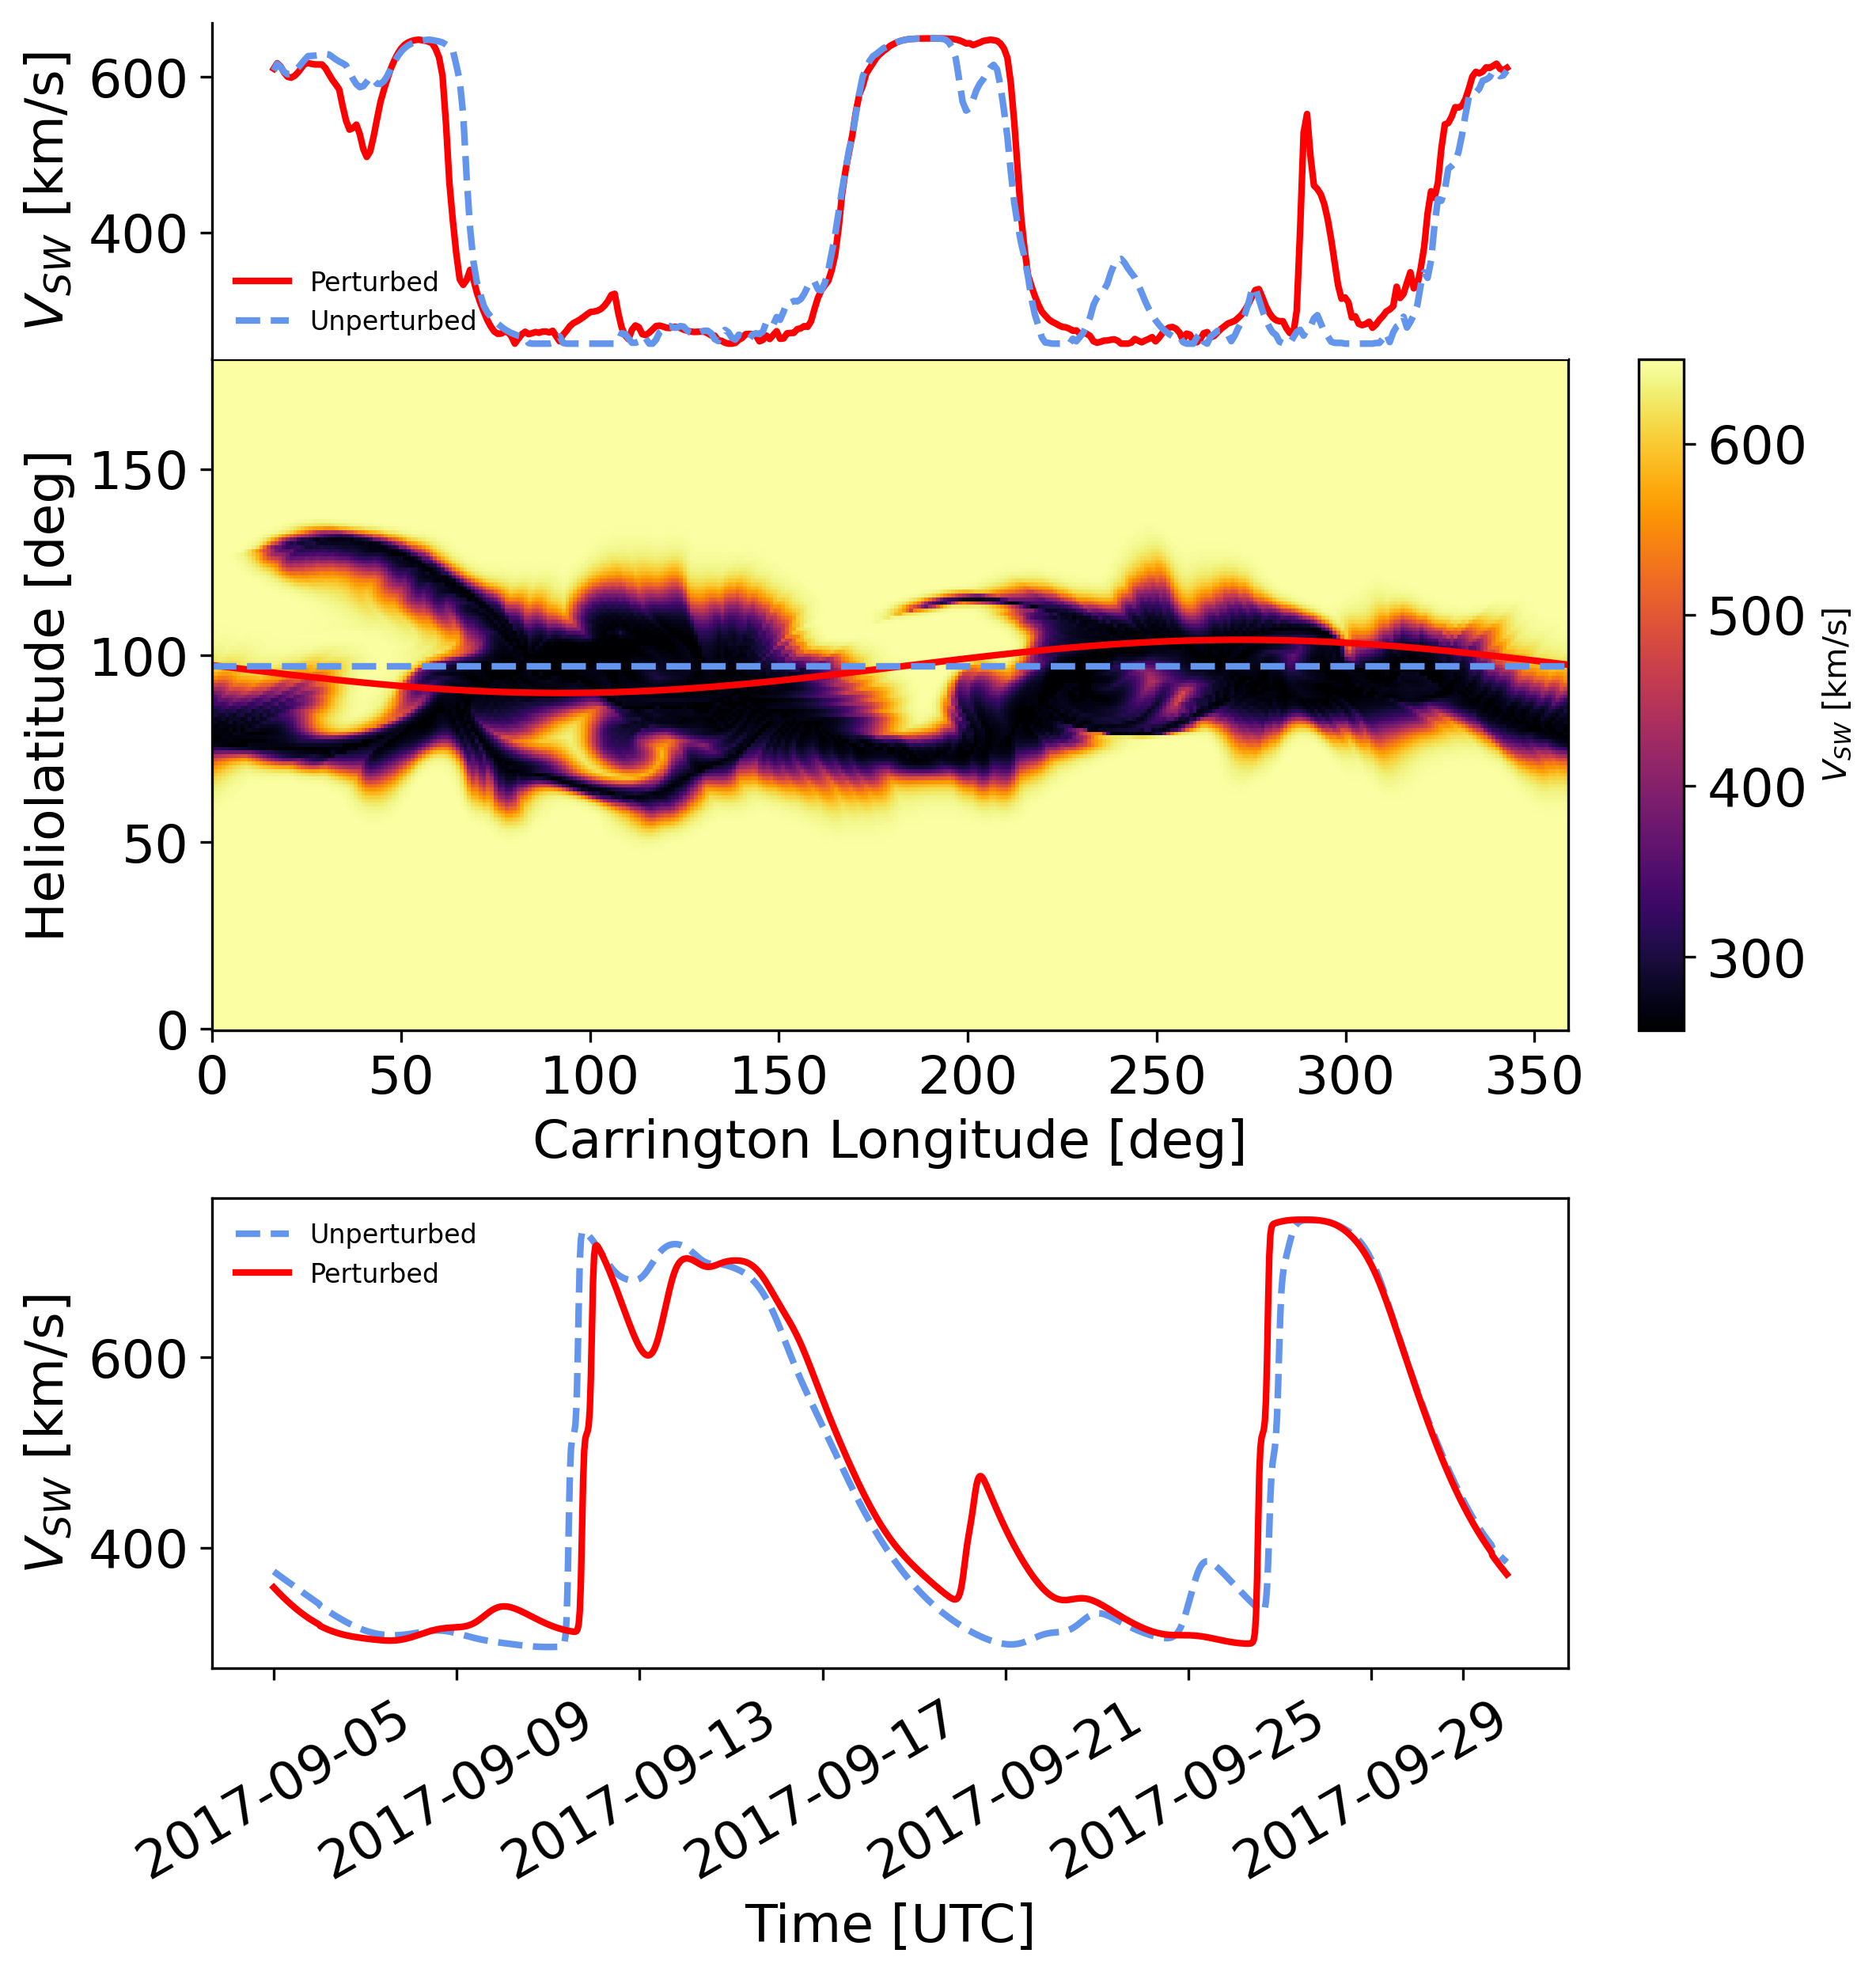

In [5]:
fig = plt.figure(figsize = (8,9),dpi=300)

# Create a 2 X 2 grid 
gs = grd.GridSpec(4, 2, height_ratios=[5,10,2.5,7], width_ratios=[30,1], wspace=0.1, hspace=0)

# MAS map plot
ax = plt.subplot(gs[2])
p = ax.imshow(MAS_vr_map,aspect = 'auto', origin = 'lower', cmap = 'inferno')
p_sub_earth_path = ax.plot(MAS_vr_longs.to(u.deg), sub_earth_path_pert[0].to(u.deg), color = 'red', lw = 2)
earth_lat_path = ax.plot(MAS_vr_longs.to(u.deg), (np.ones(360)*E_lat.to(u.deg)+90*u.deg), color = 'cornflowerblue', lw = 2, linestyle = '--')
ax.set_xlabel('Carrington Longitude [deg]')
ax.set_ylabel('Heliolatitude [deg]')
ax.set_xlim(0,359)
#ax.set_xticklabels(fontsize = '10')

# Colour bar on it's own axis
colorAx = plt.subplot(gs[3])
cb = plt.colorbar(p, cax = colorAx, aspect = 40)
cb.set_label(r'$V_{SW}$ [km/s]', fontsize = 10)

# Velocity profile plot
ax2 = plt.subplot(gs[0])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_xticks([])
#ax2.tick_params(axis='x', direction = 'in', labelbottom='off')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off'  # labels along the bottom edge are off)
)
#ax2.set_xticklabels([])

ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
ax2.set_ylabel(r'$V_{SW}$ [km/s]')
#ax2.plot(MAS_vr_longs.to(u.deg),velocity_boundary, lw=1, color = 'red')
ax2.plot(MAS_vr_longs.to(u.deg), interpolated_velocity_boundary, lw=2, color = 'red', label = 'Perturbed')
ax2.plot(MAS_vr_longs.to(u.deg), earth_latitude_velocity_boundary, lw=2, color = 'cornflowerblue', label = 'Unperturbed', linestyle = '--')
ax2.legend(fontsize = 8, frameon = False, loc = 'lower left')

ax3 = plt.subplot(gs[6])
ax3.plot(df_unpert['time'], df_unpert['vsw'], label = 'Unperturbed', color = 'cornflowerblue', linestyle = '--',lw=2)
ax3.plot(df_pert['time'], df_pert['vsw'], label = 'Perturbed', color = 'red',lw=2)
ax3.legend(frameon=False, fontsize = 8)
ax3.set_ylabel(r'$V_{SW}$ [km/s]')
ax3.set_xlabel('Time [UTC]')
#ax3.set_xticks([dt.strftime("%Y-%m-%d") for dt in df_pert['time'][::100]])
ax3.set_xticklabels([dt.strftime("%Y-%m-%d") for dt in df_pert['time'][::170]], rotation = 30)

fname = 'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_03\\HUXt_forecast_example.svg'
plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
plt.tight_layout()
plt.show()

#### Getting Carrington rotations of Solar min, Solar max, and Solar intermediate for solar cycle 24

In [6]:
# Load sunspot number data
filepath = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\SN_m_tot_V2.0.csv'
ssn = sunspots.LoadSSN(filepath = filepath)

# Start and end date of solar cycle 24
solar_start = datetime.date.fromisoformat('2008-12-01')
solar_end = datetime.date.fromisoformat('2020-01-01')

# Isolate solar cycle 24 in sunspot number data
solar_cycle_24 = ssn.set_index('datetime')
solar_cycle_24 = solar_cycle_24[solar_start:solar_end]

solar_max_peak_idx = np.argwhere(solar_cycle_24['sai'].to_numpy() == 1)[0][0]

sc_24_rise = solar_cycle_24.iloc[:solar_max_peak_idx+1]
sc_24_fall = solar_cycle_24.iloc[solar_max_peak_idx-1:]

def get_min_max_other(df_sai):

    # isolate solar min/max/intermediate values by solar activity index
    solar_min_mask = df_sai['sai'] < 0.33
    solar_min_mask = solar_min_mask[solar_min_mask!=0]

    solar_max_mask = df_sai['sai']  > 0.66
    solar_max_mask = solar_max_mask[solar_max_mask!=0]

    solar_other_mask = (df_sai['sai'] >= 0.33) & (df_sai['sai'] <= 0.66)
    solar_other_mask = solar_other_mask[solar_other_mask!=0]

    # get carrington rotations of each section of solar cycle
    converted_min_CR_list = np.unique(np.round(carrington_rotation_number(solar_min_mask.index),0).astype(int))
    converted_max_CR_list = np.unique(np.round(carrington_rotation_number(solar_max_mask.index),0).astype(int))
    converted_other_CR_list = np.unique(np.round(carrington_rotation_number(solar_other_mask.index),0).astype(int))

    # get carrington rotations of each section of solar cycle
    solar_min_CR_list = np.arange(np.min(converted_min_CR_list), np.max(converted_min_CR_list))
    solar_max_CR_list = np.arange(np.min(converted_max_CR_list), np.max(converted_max_CR_list))
    solar_other_CR_list = np.arange(np.min(converted_other_CR_list), np.max(converted_other_CR_list))
    
    return solar_min_CR_list, solar_max_CR_list, solar_other_CR_list


solar_min_list = []
solar_max_list = []
solar_other_list = []

for df_ in [sc_24_rise, sc_24_fall]:

    solar_min, solar_max, solar_other = get_min_max_other(df_)
    solar_min_list.append(solar_min)
    solar_max_list.append(solar_max)
    solar_other_list.append(solar_other)


# create dictionary for use later
solar_era_dict = {'min':np.concatenate(solar_min_list), 'other':np.concatenate(solar_other_list), 'max':np.concatenate(solar_max_list)}
CR_chunk_key = ['min', 'other', 'max']

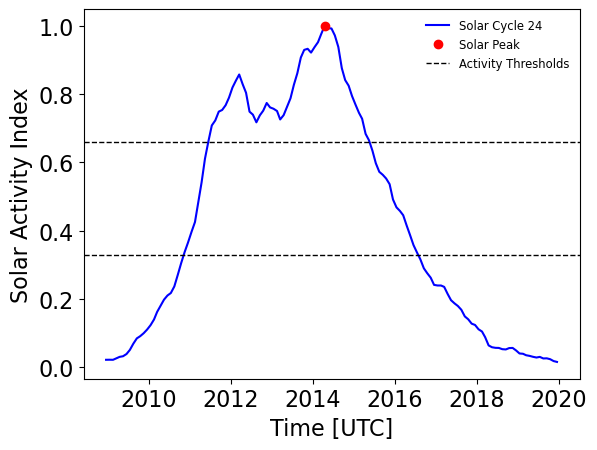

In [7]:
solar_max_peak_idx = np.argwhere(solar_cycle_24['sai'].to_numpy() == 1)

plt.plot(solar_cycle_24['sai'], label = 'Solar Cycle 24', color = 'blue')
plt.plot(solar_cycle_24.index[solar_max_peak_idx], 1, marker = 'o', color = 'red', label = 'Solar Peak', linestyle = '')
plt.axhline(0.33, lw = 1, linestyle = '--', color = 'black', label = 'Activity Thresholds')
plt.axhline(0.66, lw = 1, linestyle = '--', color = 'black')
plt.legend(frameon = False, loc = 'upper right', fontsize = 'small')
plt.xlabel('Time [UTC]')
plt.ylabel('Solar Activity Index')


fname = 'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_02\\Solar_Eras.svg'
#plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')


plt.show()


In [522]:
ensemble_size = 100

for key in CR_chunk_key:  

    # Latitude perturbation parameters
    lat_dev_list = [0,5,10,15,20,25,30,35,40]

    CR_chunk = solar_era_dict[key] # List of CR associated with given solar era

    chi_set_list = []

    for lat_dev in lat_dev_list:

        ensemble_sets = [] # List to store each CR ensemble set 

        # Read in ensemble members per CR
        for CR in CR_chunk:
            ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
            ensemble_members = [df.set_index('datetime') for df in ensemble_members]
            ensemble_sets.append(ensemble_members)

        chi_list = chi_rank_over_longitude_range(ensemble_sets=ensemble_sets, long_min = min(lat_dev_list), 
                                                 long_max=max(lat_dev_list), increments=len(lat_dev_list), ensemble_size=ensemble_size)
        chi_set_list.append(chi_list)

    save_chi_arr_to_file(chi_set_list=chi_set_list, era_key=key)

In [8]:

rank_histogram_grids = [read_rank_hist_file(key) for key in CR_chunk_key]


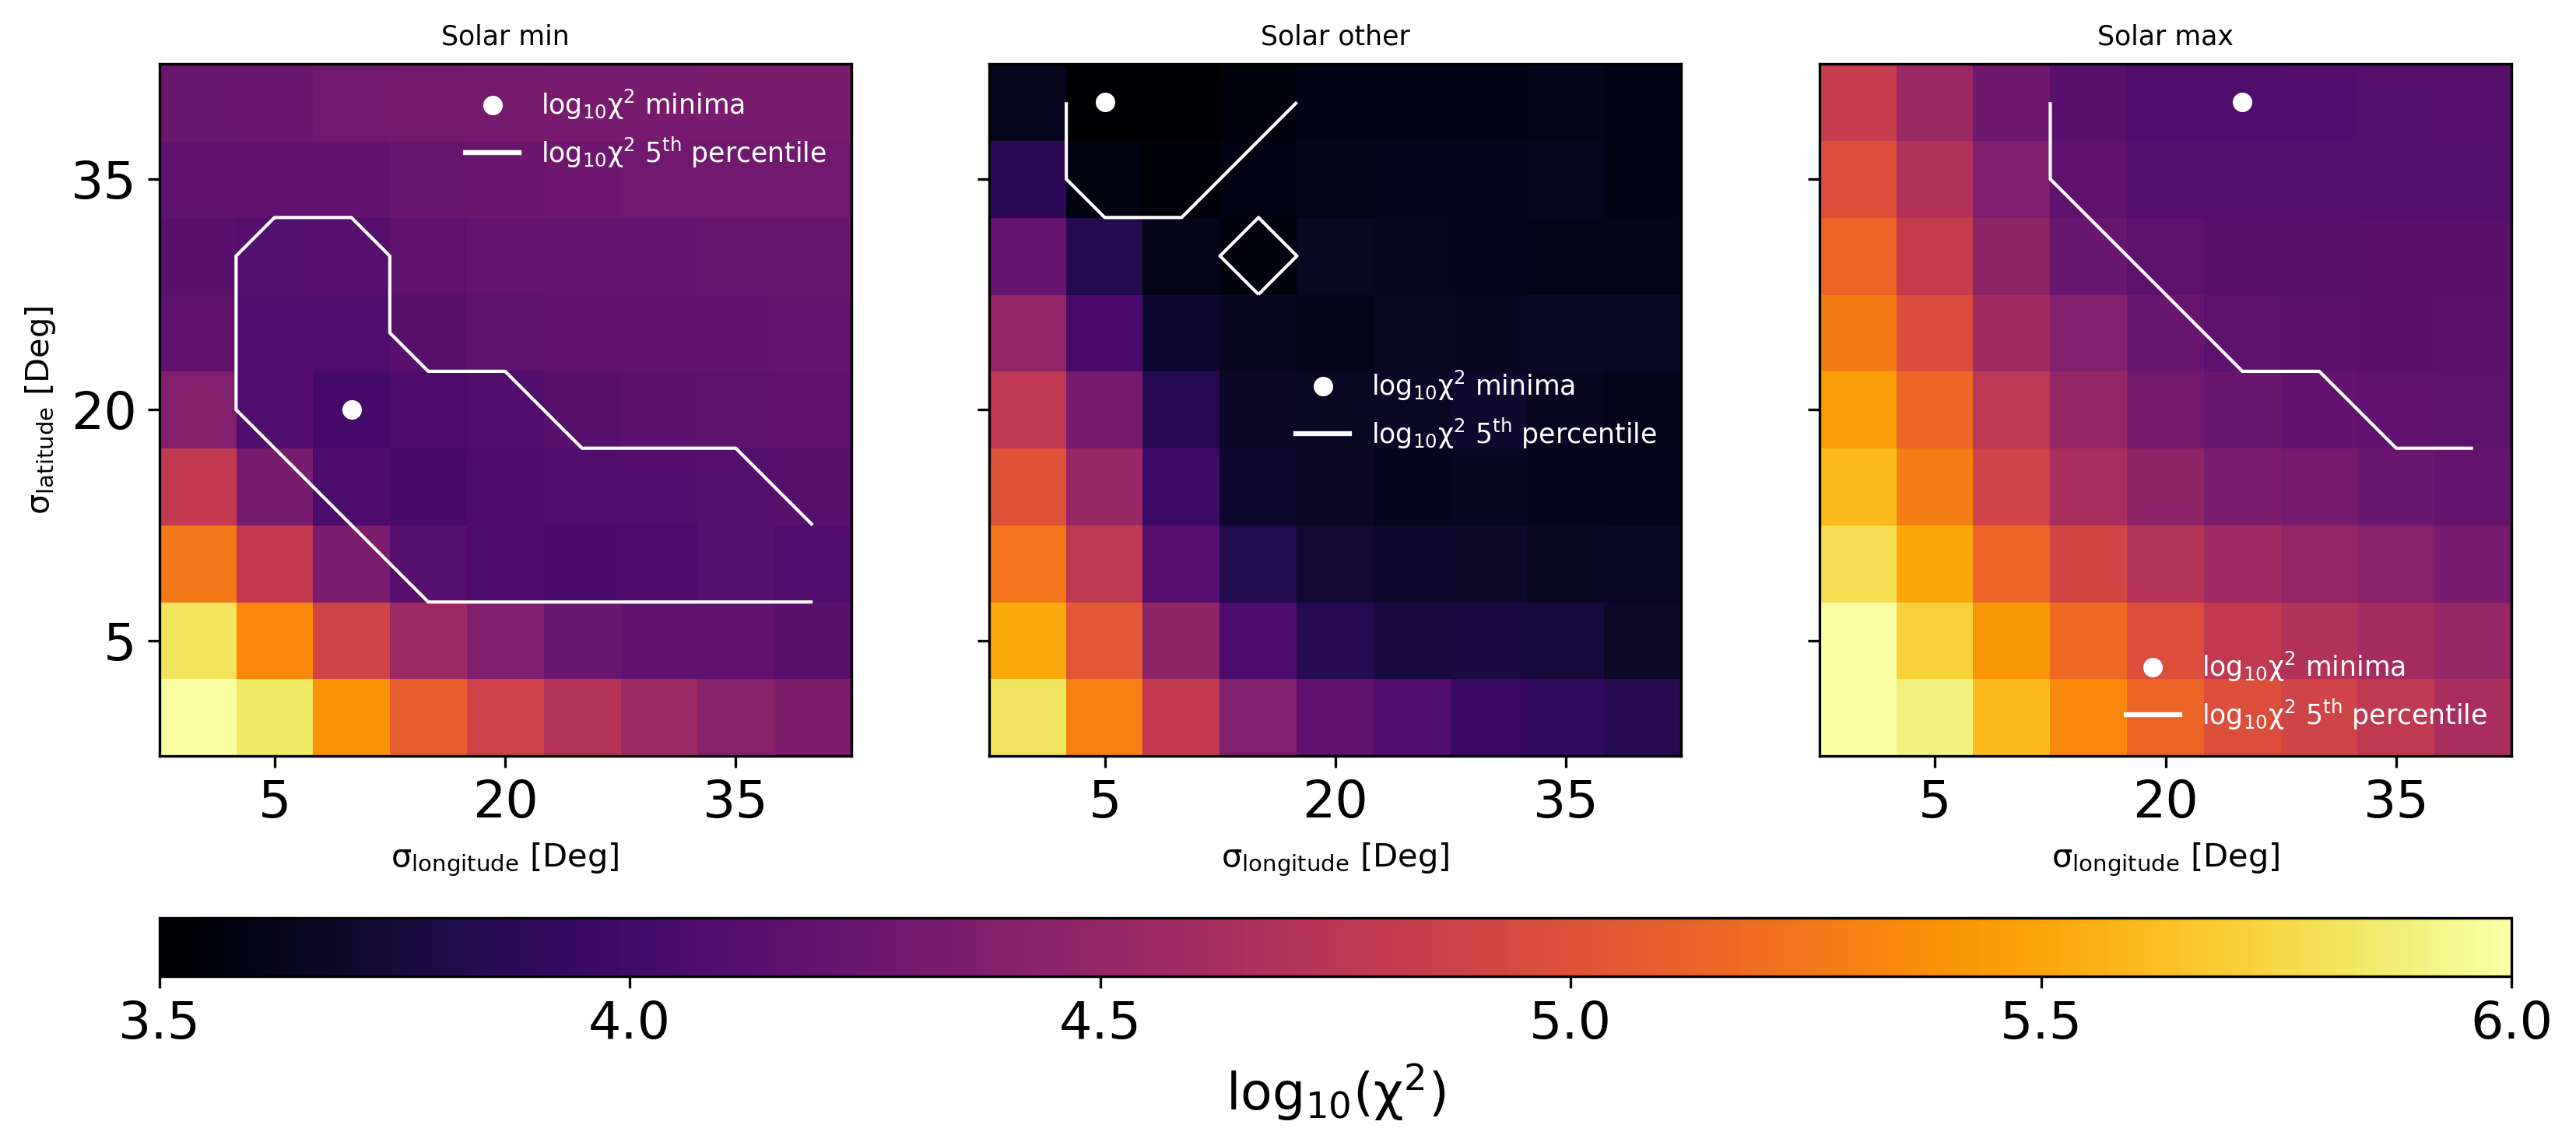

In [249]:

fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (13,6), sharex = True, sharey = True, dpi=300)
axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

loc_key = ['upper right', 'center right', 'lower right']

for i, key in enumerate(CR_chunk_key):

    rank_hist = rank_histogram_grids[i]

    im = axes[i].imshow(np.log10(rank_hist), cmap='inferno', origin = 'lower', vmin = 3.5, vmax = 6) 

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_5percent_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.05
    mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]

    axes[i].set_title(f'Solar {key}', fontsize = 'small')

    axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'white', lw = 0, label = r'$\mathrm{\log_{10}{\chi^2}}$ minima')
    axes[i].plot(mindex[1], mindex[0], color = 'white', label = r'$\mathrm{\log_{10}{\chi^2}~5^{th}}$ percentile')
    contours = axes[i].contour(within_5percent_of_min, levels = [0.5], colors='white', corner_mask = False, 
                               linewidths=1, label = r'$\mathrm{5^th percentile range}$')
    
    axes[i].legend(frameon = False, fontsize = 'small', labelcolor='linecolor', loc = loc_key[i])



axes[0].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[0].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
axes[0].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = [0,1,2]
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.15, orientation = 'horizontal', aspect = 40) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'$\mathrm{{log_{{10}}(\chi^2)}}$')

#plt.tight_layout()

fname = 'ChiSquareGrids_MMO.svg'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_03\\{fname}'
plt.savefig(path, format = 'svg', dpi = 300, bbox_inches='tight')

plt.show()

#### Looking at the calibration curve of ensembles with best/worse distributed rank histograms

In [45]:
# Enesmble data parameters
key = 'min'
lat_dev = 20
long_dev = 10
ensemble_size = 100
event_threshold = 400

# Compute calibration curve for best parameters at solar min
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

In [46]:
def rmsd_of_cal_curve(cal_curve):

    #compute root mean square deviation from ideal calibration line (the centre diagonal line)
    rmsd = np.sqrt((((cal_curve[0] - cal_curve[1])**2).sum()).mean())

    return rmsd

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[7826, 7878, 8021, 5550, 5045, 3961, 2429, 1670, 1379, 716]
[7826, 7878, 8021, 5550, 5045, 3961, 2429, 1670, 1379, 716]


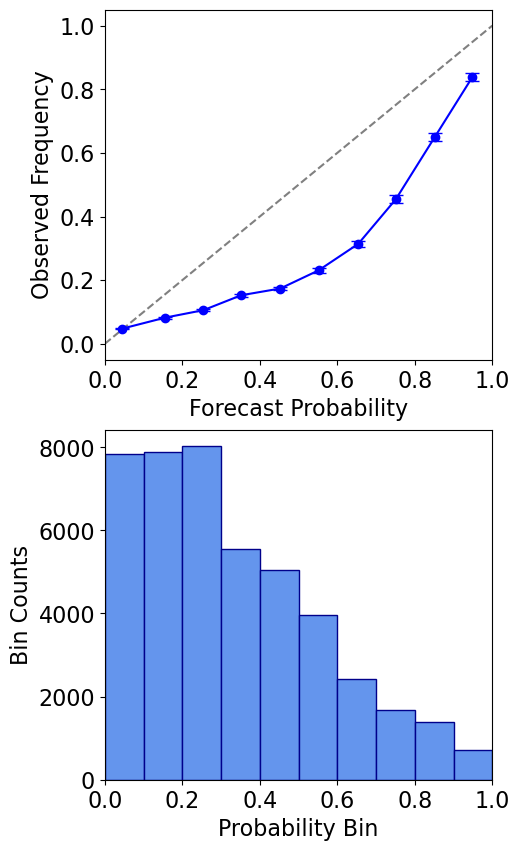

In [58]:
#np.random.seed(0)
ensemble_size = 100
event_threshold = 500
forecast_probabilities = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, threshold=event_threshold, ensemble_size=ensemble_size)
observations = eef.generate_catagorical_forecast(forecast=observed_data['V'], threshold=event_threshold).to_numpy()
num_bins = 10
# Define bins for probabilities
bins = np.linspace(0, 1, num_bins+1)
print(bins)

# Group forecast probabilities and observations based on bins
digitized = np.digitize(forecast_probabilities, bins)

grouped_data = [observations[digitized == i] for i in range(1, len(bins))]
grouped_probabilities = [forecast_probabilities[digitized == i] for i in range(1, len(bins))]

# Number of bootstrap samples
n_bootstraps = 100

# Bootstrap resampling for each bin
bootstrap_errors = []
sample_sizes = [sum(digitized == i) for i in range(1, len(bins))]
print(sample_sizes)

bootsstrap_sample_sizes = []

for group_data, group_probabilities in zip(grouped_data, grouped_probabilities): # Isolate each group of binned forecast probabilities
    bootstrapped_errors = []
    bootsstrap_sample_sizes.append(len(group_data))
    for _ in range(n_bootstraps):
        bootstrapped_sample = resample(group_data)
        #print(len(bootstrapped_sample))
        try:
            observed_frequency, mean_forecast_prob = calibration_curve(np.ones(len(bootstrapped_sample)), bootstrapped_sample, 
                                                                       n_bins=1, pos_label=1, strategy='uniform')
        except ValueError: #raised if group has zero size (I think)
            pass

        bootstrapped_errors.append(abs(mean_forecast_prob - observed_frequency))
    bootstrap_errors.append(np.std(bootstrapped_errors))

# Calculate mean forecast probability and observed frequency for original data
observed_frequency, mean_forecast_prob = calibration_curve(observations, forecast_probabilities, n_bins=num_bins, strategy='uniform')
print(bootsstrap_sample_sizes)
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (5,10))

# Plot calibration curve with error bars
axes[0].errorbar(mean_forecast_prob, observed_frequency, yerr=np.asarray(bootstrap_errors).T, fmt='o', linestyle='-', capsize=5, color = 'blue')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
axes[0].set_xlabel('Forecast Probability')
axes[0].set_ylabel('Observed Frequency')
axes[0].set_xlim(0,1)


axes[1].bar(bins[:-1], bootsstrap_sample_sizes, align ='edge', edgecolor = 'darkblue', width = 0.1, color = 'cornflowerblue')
axes[1].set_xlim(0,1)
axes[1].set_ylabel('Bin Counts')
axes[1].set_xlabel('Probability Bin')
#axes[1].set_xticklabels(np.round(bins,1))


plt.show()

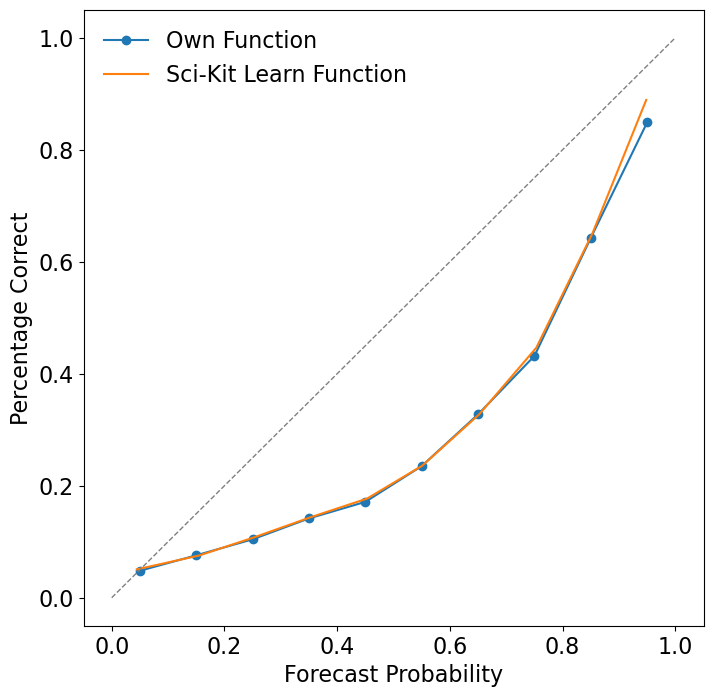

In [221]:
event_threshold = 500 #km/s

probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, 
                                                        threshold=event_threshold, ensemble_size=ensemble_size)
y_prob = probabilistic_forecast
y_true = eef.generate_catagorical_forecast(forecast=observed_data['V'], threshold=event_threshold)
num_bins = 10

# Bin probabilities
bins = np.linspace(0, 1, num_bins + 1) # Generate bins
bin_indices = np.digitize(y_prob, bins) # Return the indices of the bins to which each value in input array belongs.

# Calculate percentage correct in each bin
observed_frequency = []
for bin_num in range(1, num_bins + 1):
    mask = (bin_indices == bin_num) # Create mask which isolates all forecast indices within bin being looped over
    percentage = np.mean(y_true[mask]) # calculate percentage as fraction of correct forecasts of binned indices
    observed_frequency.append(percentage)

# Calculate mean probability in each bin
mean_probabilities = [(bins[i] + bins[i + 1]) / 2 for i in range(num_bins)]

prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_prob, n_bins=num_bins)

# Plot the calibration curve
plt.figure(figsize=(8, 8))
plt.plot(mean_probabilities, observed_frequency, marker='o', linestyle='-', label = 'Own Function')
plt.plot(prob_pred, prob_true, label = 'Sci-Kit Learn Function')
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'grey')
plt.xlabel('Forecast Probability')
plt.ylabel('Percentage Correct')
plt.legend(frameon = False)
plt.show()

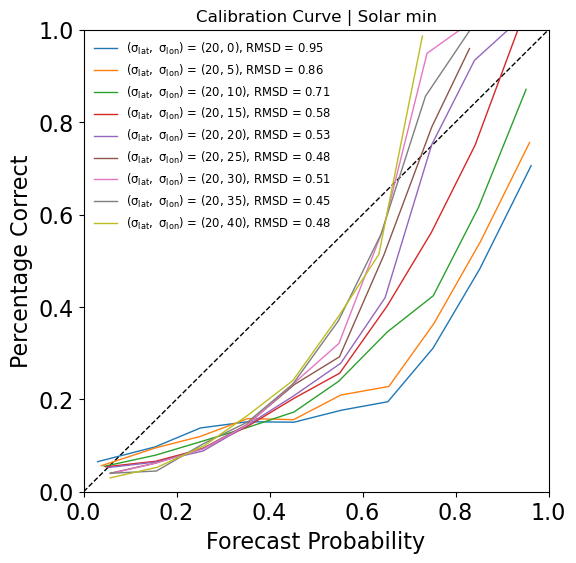

In [543]:


# Enesmble data parameters
key = 'min'
lat_dev = 20
ensemble_size = 100
event_threshold = 500

# Compute calibration curve for best parameters at solar min
CR_chunk = solar_era_dict[key]

long_dev_list = np.arange(0,45,5)

rmsd_across_long = []

plt.figure(figsize = (6,6))
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')

for long_dev in long_dev_list:

    ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

    cal_curve = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

    rmsd = rmsd_of_cal_curve(cal_curve)
    plt.plot(cal_curve[1], cal_curve[0], lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev}, {long_dev}), RMSD = {rmsd:.2f}')

    rmsd_across_long.append(rmsd)

plt.xlim(0,1)
plt.ylim(0,1)

plt.legend()
plt.ylabel('Observed Frequency')
plt.xlabel('Forecast Probability')
plt.title(f'Calibration Curve | Solar min')
plt.legend(frameon = False, fontsize = 'small')

plt.show()


In [15]:
# Enesmble data parameters
key = 'min'
lat_dev = 5
long_dev = 5
ensemble_size = 100
event_threshold = 500

# Compute calibration curve 
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve_low_pert = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

# Enesmble data parameters
key = 'min'
lat_dev = 40
long_dev = 40
ensemble_size = 100
event_threshold = 500

# Compute calibration curve
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve_high_pert = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

# Enesmble data parameters
key = 'min'
lat_dev = 20
long_dev = 0
ensemble_size = 100
event_threshold = 500

# Compute calibration curve 
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve_no_pert = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)


# Enesmble data parameters
key = 'min'
lat_dev = 0
long_dev = 20
ensemble_size = 100
event_threshold = 500

# Compute calibration curve 
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

cal_curve_no_lat_pert = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)

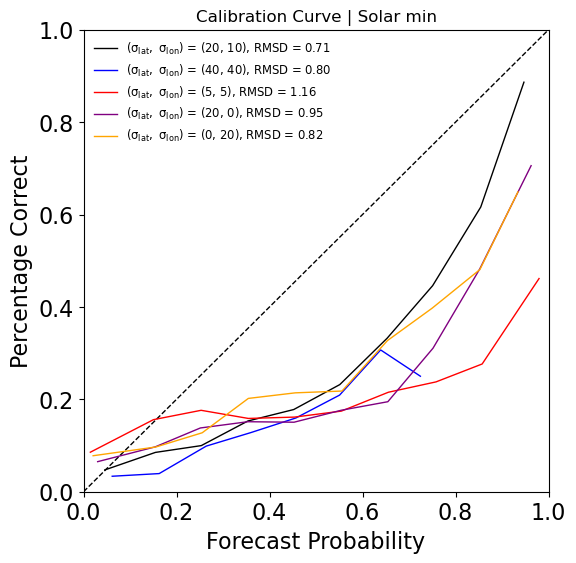

In [18]:
plt.figure(figsize = (6,6))
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')

plt.plot(cal_curve[1], cal_curve[0], color = 'black', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({20}, {10}), RMSD = {rmsd_of_cal_curve(cal_curve):.2f}')

plt.plot(cal_curve_high_pert[1], cal_curve_high_pert[0], color = 'blue', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({40}, {40}), RMSD = {rmsd_of_cal_curve(cal_curve_high_pert):.2f}')

plt.plot(cal_curve_low_pert[1], cal_curve_low_pert[0], color = 'red', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({5}, {5}), RMSD = {rmsd_of_cal_curve(cal_curve_low_pert):.2f}')

plt.plot(cal_curve_no_pert[1], cal_curve_no_pert[0], color = 'purple', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({20}, {0}), RMSD = {rmsd_of_cal_curve(cal_curve_no_pert):.2f}')


plt.plot(cal_curve_no_lat_pert[1], cal_curve_no_lat_pert[0], color = 'orange', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({0}, {20}), RMSD = {rmsd_of_cal_curve(cal_curve_no_lat_pert):.2f}')

plt.xlim(0,1)
plt.ylim(0,1)

plt.legend()
plt.ylabel('Observed Frequency')
plt.xlabel('Forecast Probability')
plt.title(f'Calibration Curve | Solar min')
plt.legend(frameon = False, fontsize = 'small')

fname = 'Calibration_Curves.svg'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\{fname}'
#plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

In [ ]:
key = 'min'

long_dev_list = [0,5,10,15,20,25,30,35,40]
lat_dev_list = [0,5,10,15,20,25,30,35,40]

event_threshold = 500
ensemble_size = 100

briers_grid = []
ROC_grid = []

calibration_curves_grid = []

CR_chunk = solar_era_dict[key]

for lat_dev in lat_dev_list:

    cal_curves_across_long = []
    for long_dev in long_dev_list:

        ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                    omni_data = omni_data, ensemble_size=ensemble_size)

        cal_curve = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data['V'], event_threshold=event_threshold, num_bins = 10)
        cal_curves_across_long.append(cal_curve)

    calibration_curves_grid.append(cal_curves_across_long)


In [ ]:

obs_freq, pred_freq = zip(*[(tup[0], tup[1]) for sublist in calibration_curves_grid for tup in sublist])

obs_freq_flat = [item for sublist in obs_freq for item in sublist]
pred_freq_flat = [item for sublist in pred_freq for item in sublist]


In [ ]:
hist = plt.hist2d(pred_freq_flat, obs_freq_flat, bins = 10, cmap = 'Greys', alpha = 0.7, label = 'All ensembles')

plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')

plt.plot(calibration_curves_grid[4][3][1], calibration_curves_grid[4][3][0], marker = 'x', color = 'red', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev_list[4]}, {long_dev_list[3]})')

plt.plot(calibration_curves_grid[1][1][1], calibration_curves_grid[1][1][0], marker = 'x', color = 'darkblue', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev_list[1]}, {long_dev_list[1]})')

plt.plot(calibration_curves_grid[8][8][1], calibration_curves_grid[8][8][0], marker = 'x', color = 'purple', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev_list[8]}, {long_dev_list[8]})')


plt.colorbar()
plt.ylabel('Observed Frequency')
plt.xlabel('Forecast Probability')
plt.title(f'Calibration Curve | Solar {key}')
plt.legend(frameon = False, fontsize = 'small')

plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

#### Briers score and ROC score evaluation

In [118]:
key = 'min'

long_dev_list = [0,5,10,15,20,25,30,35,40]
lat_dev_list = [0,5,10,15,20,25,30,35,40]

event_threshold = 460
probability_threshold = 0.9
ensemble_size = 100

briers_grid = []
ROC_grid = []

for lat_dev in lat_dev_list:

    #initialise lists to store briers score + roc score across sigma_long
    temp_briers_scores_list = []
    temp_ROC_scores_list = []

    for long_dev in long_dev_list:

        CR_chunk = solar_era_dict[key]
        ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                    omni_data = omni_data, ensemble_size=ensemble_size)
        
       # temp_briers_scores_list.append(eef.compute_brier_score_probabilistic(ensemble_members=ensemble_members, observed_data=observed_data['V'], 
        #                                                                                threshold=event_threshold, ensemble_size=ensemble_size))
            
        roc_curve = eef.generate_roc_curve_from_ensemble(ensemble_members=ensemble_members, observed_data=observed_data['V'], 
                                                        threshold_range=(200,800), threshold_num=30, probability_threshold = probability_threshold)

        temp_ROC_scores_list.append(compute_roc_score(roc_curve=roc_curve))

   # briers_grid.append(temp_briers_scores_list)
    ROC_grid.append(temp_ROC_scores_list)

#save_brier_scores_to_file(briers_grid, era_key='min', event_threshold=event_threshold)
save_roc_scores_to_file(ROC_grid, era_key='min', prob_thresh=probability_threshold)

In [10]:
event_threshold = 550
probability_threshold = 0.5
ensemble_size = 100

briers_grids = [read_brier_scores_file(key, event_threshold) for key in ['min']]
ROC_grids = [read_ROC_scores_file(key, probability_threshold) for key in ['min']]

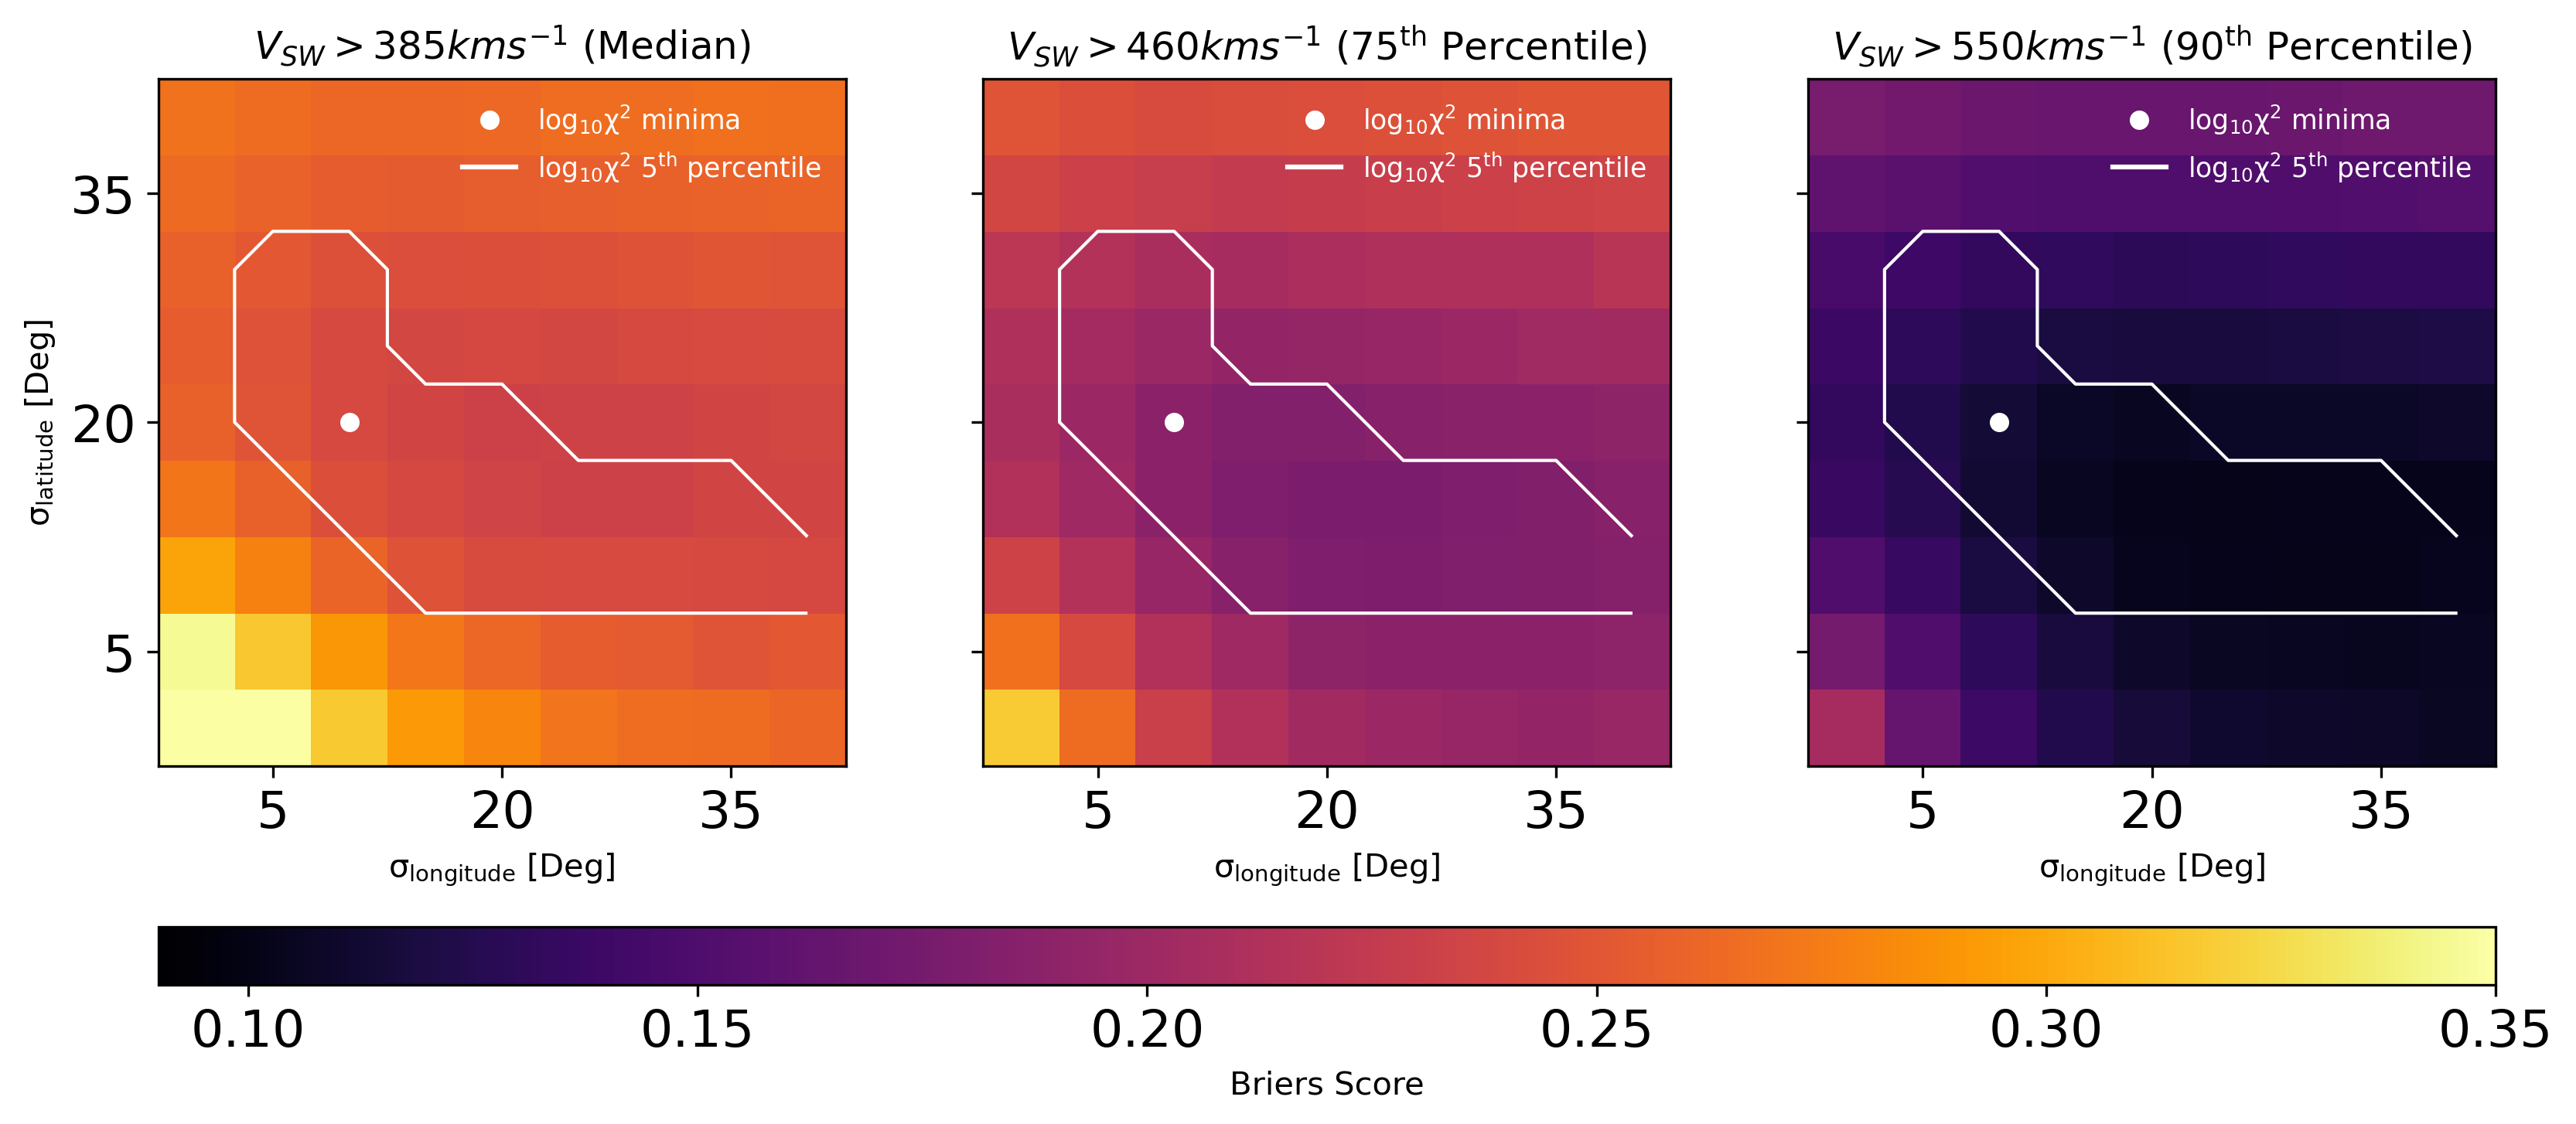

In [248]:
event_thresholds = [385,460,550]
ensemble_size = 100
key = 'min'
threshold_key = ['Median', r'$\mathrm{75^{th}}$ Percentile', r'$\mathrm{90^{th}}$ Percentile'] # plotting labels

briers_grids = [read_brier_scores_file(key, event_thrsh) for event_thrsh in event_thresholds]

# Getting minima and 5th percentile contours from rank histogram score grids
rank_hist = rank_histogram_grids[0]
grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
within_5percent_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.05
mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (13,6), sharey = True, dpi=300)

for i, BSG in enumerate(briers_grids):
    
    im = axes[i].imshow(BSG, cmap='inferno', origin = 'lower', vmin=0.09, vmax = 0.35)
    axes[i].set_title(f'$V_{{SW}}>{event_thresholds[i]}kms^{{-1}}$ ({threshold_key[i]})')

    axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'white', lw = 0, label = r'$\mathrm{\log_{10}{\chi^2}}$ minima')
    axes[i].plot(mindex[1], mindex[0], color = 'white', label = r'$\mathrm{\log_{10}{\chi^2}~5^{th}}$ percentile')
    contours = axes[i].contour(within_5percent_of_min, levels = [0.5], colors='white', corner_mask = False, 
                               linewidths=1, label = r'$\mathrm{5^th percentile range}$')
    
    axes[i].legend(frameon = False, fontsize = 'small', labelcolor='linecolor')

axes[0].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[0].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
axes[0].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = [0,1,2]
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar1 = fig.colorbar(im, ax=axes, pad=0.15, orientation = 'horizontal', aspect = 40) #, anchor = (-2,-2), aspect = 30)  
cbar1.set_label(f'Briers Score', fontsize = 'medium')

fname = 'Briers_score_solar_min.svg'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_03\\{fname}'
plt.savefig(path, format = 'svg', dpi = 300, bbox_inches='tight')


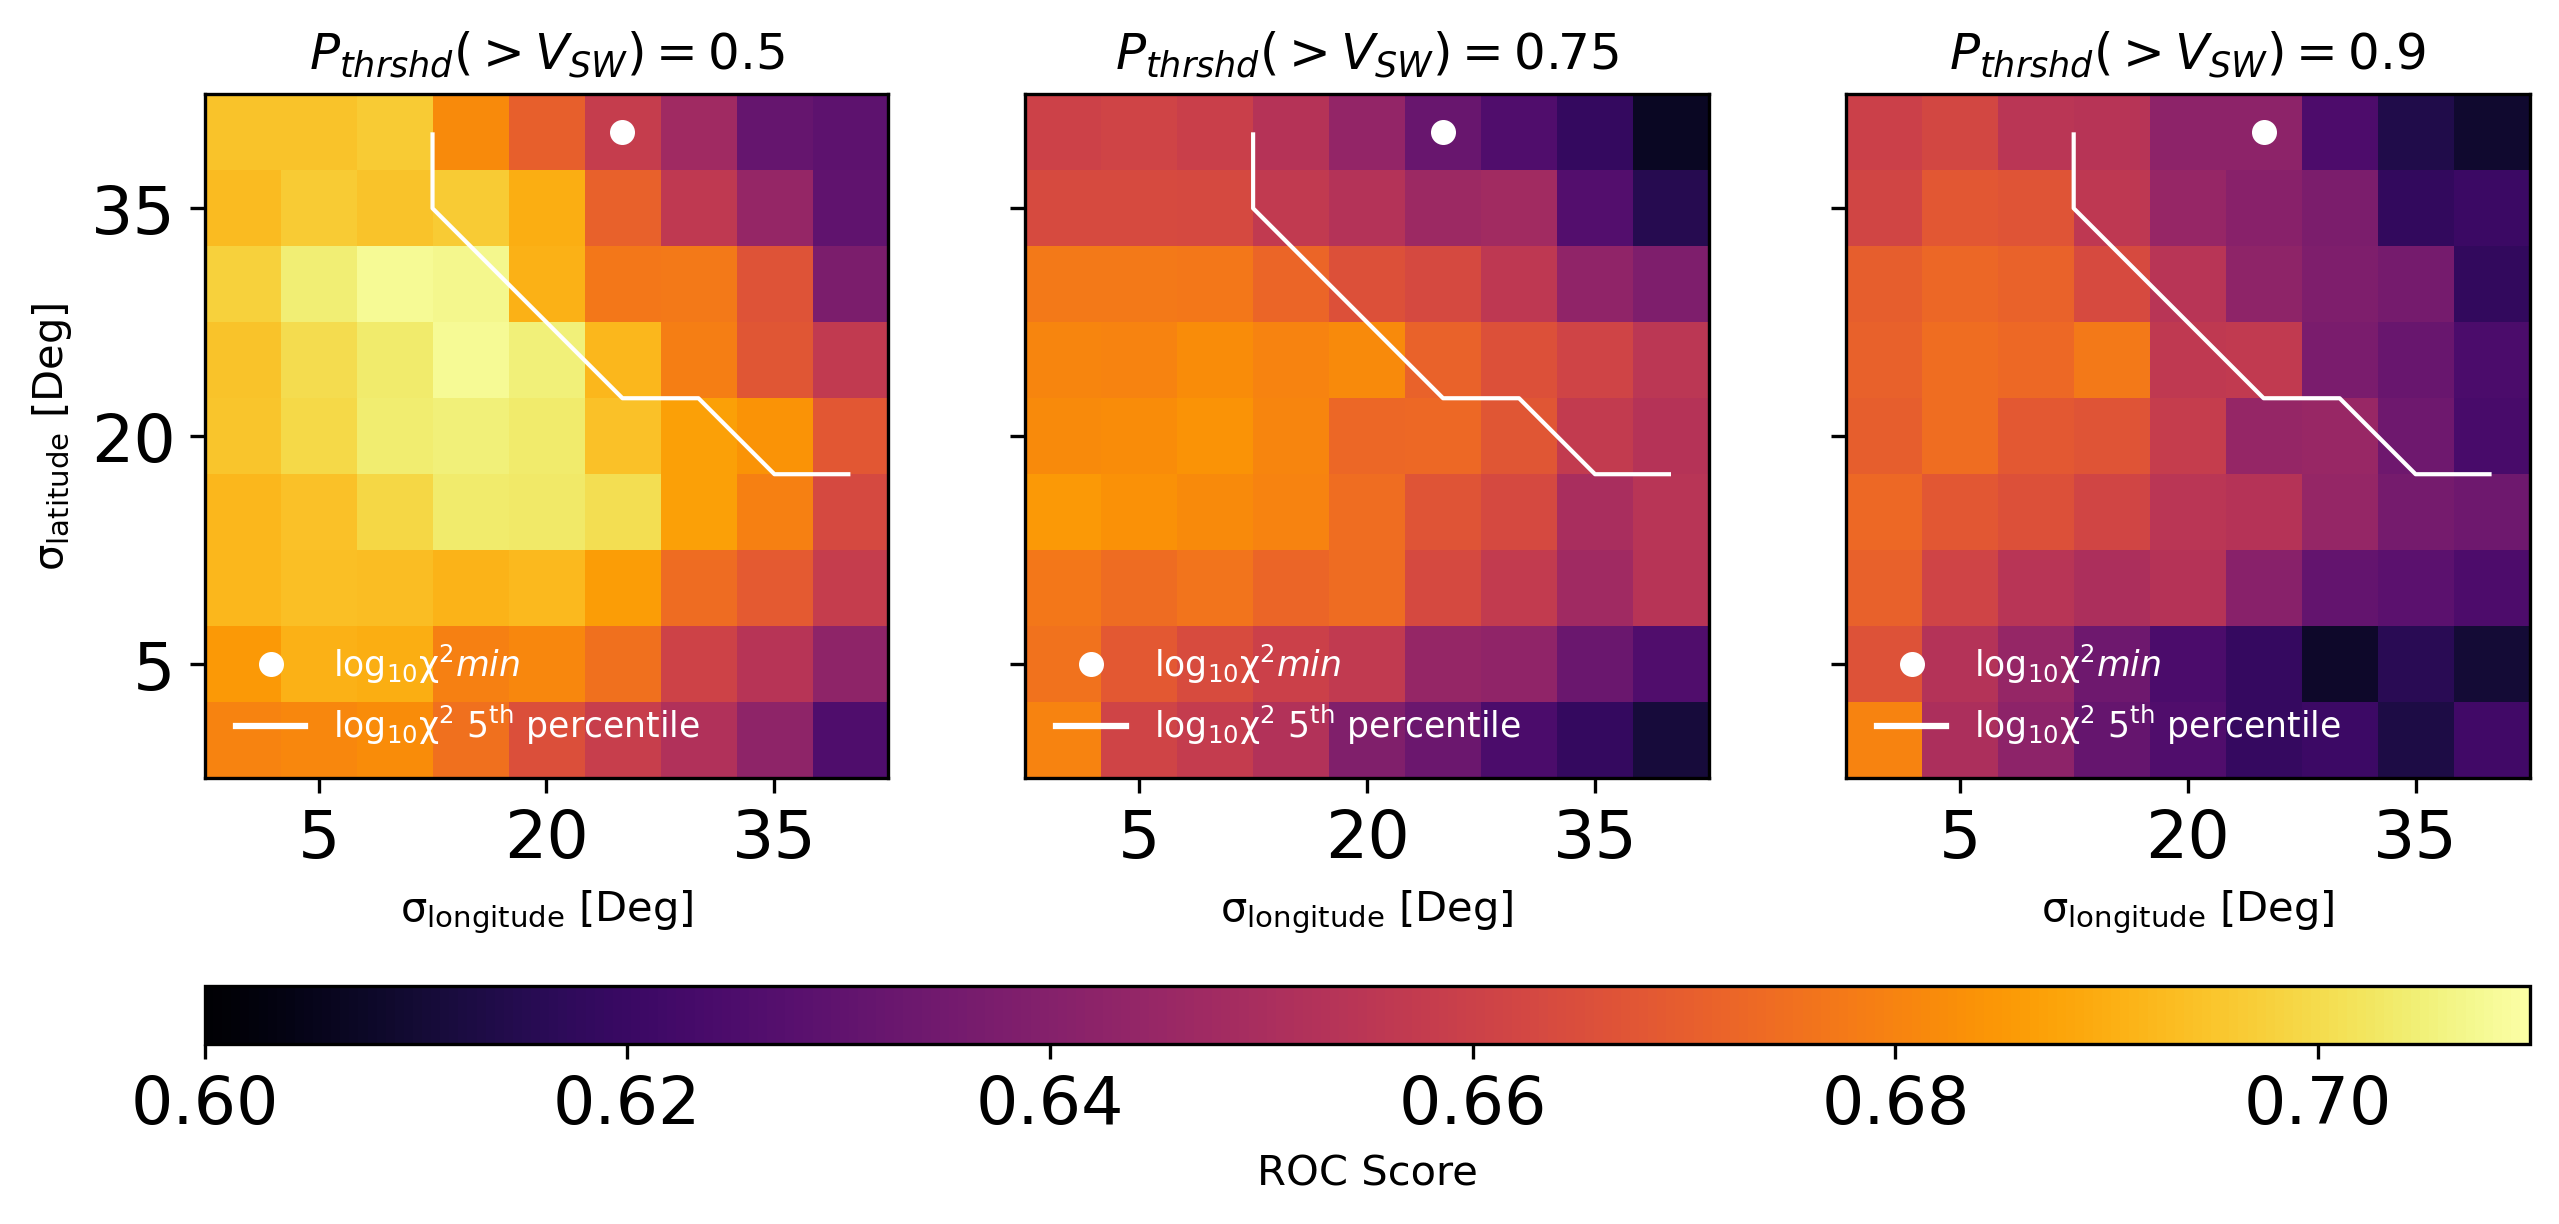

In [247]:
probability_thresholds = [0.5,0.75,0.9]
ensemble_size = 100
key = 'min'

ROC_grids = [read_ROC_scores_file(key, pt) for pt in probability_thresholds]

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,6), sharey = True, dpi=300)

for i, ROCG in enumerate(ROC_grids):
    
    im = axes[i].imshow(ROCG, cmap='inferno', origin = 'lower', vmin=0.6, vmax = 0.71)
    axes[i].set_title(f'$P_{{thrshd}}(>V_{{SW}})={probability_thresholds[i]}$')

    axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'white', lw = 0, label = r'$\mathrm{\log_{10}{\chi^2}}min$')
    axes[i].plot(mindex[1], mindex[0], color = 'white', label = r'$\mathrm{\log_{10}{\chi^2}~5^{th}}$ percentile')
    contours = axes[i].contour(within_5percent_of_min, levels = [0.5], colors='white', corner_mask = False, 
                               linewidths=1, label = r'$\mathrm{5^th percentile range}$')
    
    axes[i].legend(frameon = False, fontsize = 'small', labelcolor='linecolor')

axes[0].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[0].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
axes[0].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = [0,1,2]
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar1 = fig.colorbar(im, ax=axes, pad=0.15, orientation = 'horizontal', aspect = 40) #, anchor = (-2,-2), aspect = 30)  
cbar1.set_label(f'ROC Score', fontsize = 'medium')

fname = 'ROC_score_solar_min.svg'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_03\\{fname}'
plt.savefig(path, format = 'svg', dpi = 300, bbox_inches='tight')

plt.show()

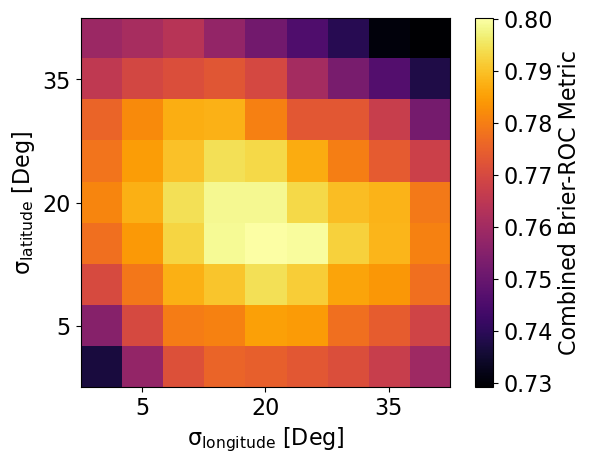

In [70]:
combined_skill_metric = ((1 - briers_grids[2]) + ROC_grids[0])/2

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

fig, ax = plt.subplots(1,1)

im = ax.imshow(combined_skill_metric, cmap='inferno', origin = 'lower') 

ax.set_yticks(np.arange(len(lat_dev_list))[1::3])
ax.set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]')
ax.set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

ax.set_xticks(np.arange(len(long_dev_list))[1::3])
ax.set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]')
ax.set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

cbar = fig.colorbar(im)
cbar.set_label('Combined Brier-ROC Metric')

plt.show()

In [32]:
def separate_score_populations(rank_hist, brier_grid):

    # Empty lists to store 
    scores_within_bounds_BS = []
    scores_out_bounds_BS = []

    ## Briers Score Distribution Separation
    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_percentile_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.05

    scores_within_bounds_BS.append(brier_grid[within_percentile_of_min])
    scores_out_bounds_BS.append(brier_grid[~within_percentile_of_min])

    scores_within_bounds_BS = np.concatenate(scores_within_bounds_BS)
    scores_out_bounds_BS = np.concatenate(scores_out_bounds_BS)

    return scores_within_bounds_BS, scores_out_bounds_BS



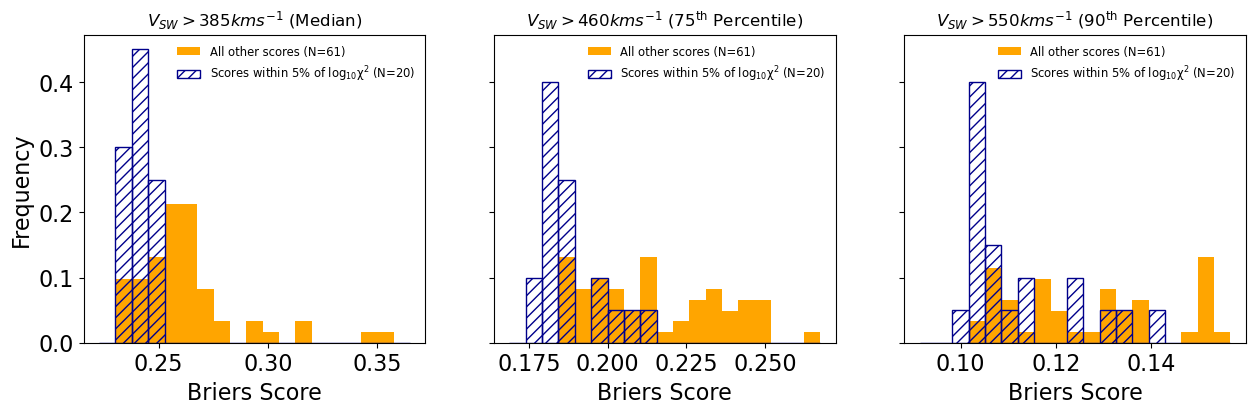

In [246]:

event_thresholds = [385,460,550]
threshold_key = ['Median', r'$\mathrm{75^{th}}$ Percentile', r'$\mathrm{90^{th}}$ Percentile']

fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey=True, figsize = (15,4))
rank_hist = rank_histogram_grids[0]
for i, ax in enumerate(axes):

    brier_grid = briers_grids[i]
    scores_within_bounds_BS, scores_out_bounds_BS = separate_score_populations(rank_hist=rank_hist, brier_grid=brier_grid)

    bins = np.linspace(np.min(scores_within_bounds_BS)-0.01,np.max(scores_out_bounds_BS)-0.05,20)

    ax.hist(scores_out_bounds_BS, label = f'All other scores (N={len(scores_out_bounds_BS)})', weights=np.ones(len(scores_out_bounds_BS))/len(scores_out_bounds_BS), 
            bins = bins, color = 'orange')
    ax.hist(scores_within_bounds_BS, label = f'Scores within 5% of $\mathrm{{\log_{{10}}{{\chi^2}}}}$ (N={len(scores_within_bounds_BS)})', 
            weights=np.ones(len(scores_within_bounds_BS))/len(scores_within_bounds_BS), bins = bins, fill = False, edgecolor = 'darkblue', hatch = '///')

    ax.set_title(f'$V_{{SW}}>{event_thresholds[i]}kms^{{-1}}$ ({threshold_key[i]})')
    ax.legend(frameon = False, fontsize = 'small')
    ax.set_xlabel(f'Briers Score')
    
axes[0].set_ylabel('Frequency')
#plt.xlim(0.12, 0.25)

fname = 'Briers_HIST_solar_min.svg'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_03\\{fname}'
plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()


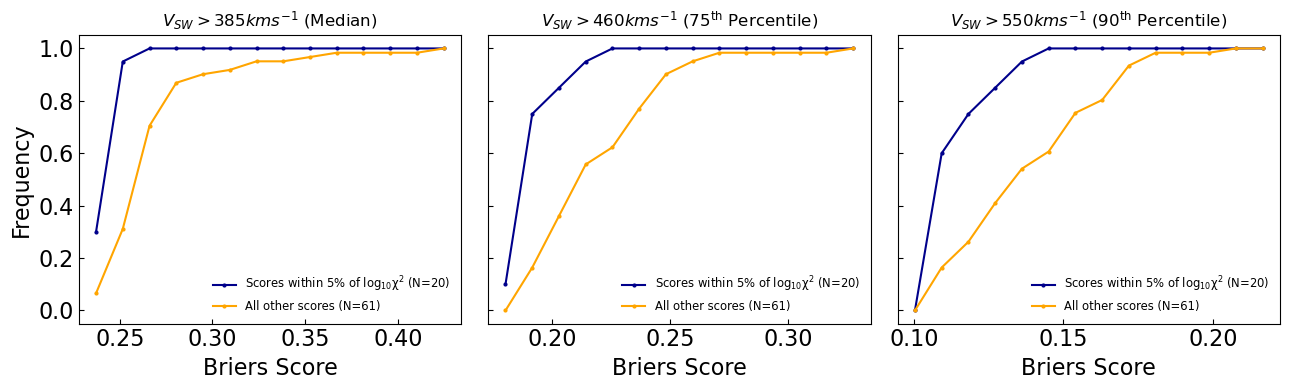

In [243]:
event_thresholds = [385,460,550]
threshold_key = ['Median', r'$\mathrm{75^{th}}$ Percentile', r'$\mathrm{90^{th}}$ Percentile']
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey=True, figsize = (13,4))
rank_hist = rank_histogram_grids[0]

for i, ax in enumerate(axes):

    brier_grid = briers_grids[i]
    scores_within_bounds_BS, scores_out_bounds_BS = separate_score_populations(rank_hist=rank_hist, brier_grid=brier_grid)

    bins = np.linspace(np.min(scores_within_bounds_BS)-0.01,np.max(scores_out_bounds_BS)+0.01,15)

    ### Computing CDF for briers scores within/without briers minima bounds
    hist_1, bin_edges_1 = np.histogram(scores_within_bounds_BS, bins = bins, normed = True)
    dx1 = bin_edges_1[1] - bin_edges_1[0]
    F1 = np.cumsum(hist_1)*dx1

    hist_2, bin_edges_2 = np.histogram(scores_out_bounds_BS, bins = bins, normed = True)
    dx2 = bin_edges_2[1] - bin_edges_2[0]
    F2 = np.cumsum(hist_2)*dx2

    hist_tot, bin_edges_tot = np.histogram(briers_grids[0], bins = bins, normed = True)
    dx_tot = bin_edges_tot[1] - bin_edges_tot[0]
    Ftot = np.cumsum(hist_tot)*dx_tot

    ax.plot(bin_edges_1[1:], F1, marker = 'o', markersize = 2, label = f'Scores within 5% of $\mathrm{{\log_{{10}}{{\chi^2}}}}$ (N={len(scores_within_bounds_BS)})', color = 'darkblue')
    ax.plot(bin_edges_2[1:], F2, marker = 'o', markersize = 2, label = f'All other scores (N={len(scores_out_bounds_BS)})', color = 'orange')

    ax.set_title(f'$V_{{SW}}>{event_thresholds[i]}kms^{{-1}}$ ({threshold_key[i]})')
    ax.tick_params(direction = 'in')
    ax.legend(frameon = False, fontsize = 'small')
    ax.set_xlabel(f'Briers Score')

axes[0].set_ylabel('Frequency')
plt.tight_layout()
#plt.xlim(0.12, 0.25)

fname = 'Briers_CDF_solar_min.svg'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_03\\{fname}'
plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

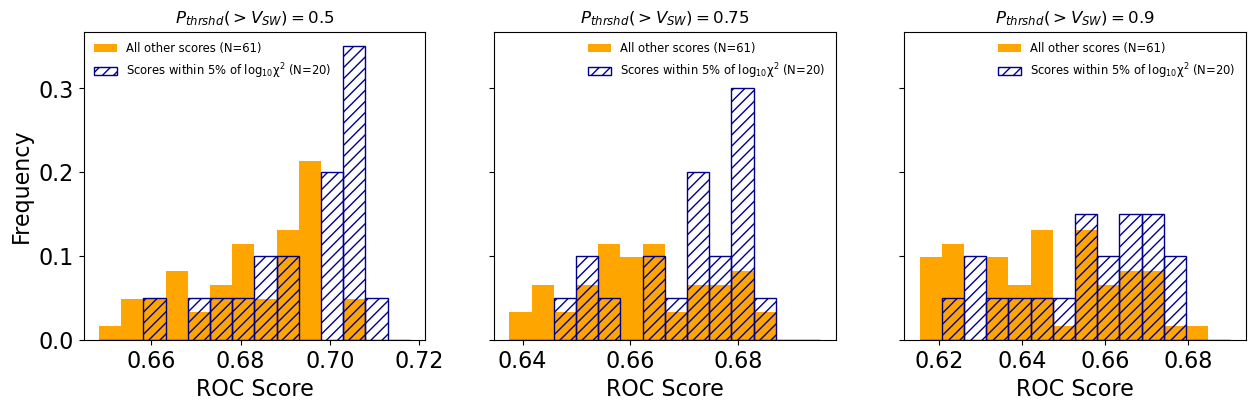

In [241]:

probability_thresholds = [0.5,0.75,0.9]
ensemble_size = 100
key = 'min'

ROC_grids = [read_ROC_scores_file(key, pt) for pt in probability_thresholds]

fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey=True, figsize = (15,4))
rank_hist = rank_histogram_grids[0]
for i, ax in enumerate(axes):

    score_grid = ROC_grids[i]
    scores_within_bounds_BS, scores_out_bounds_BS = separate_score_populations(rank_hist=rank_hist, brier_grid=score_grid)

    bins = np.linspace(np.min(scores_within_bounds_BS)-0.01,np.max(scores_out_bounds_BS)+0.01,15)

    ax.hist(scores_out_bounds_BS, label = f'All other scores (N={len(scores_out_bounds_BS)})', weights=np.ones(len(scores_out_bounds_BS))/len(scores_out_bounds_BS), 
            bins = bins, color = 'orange')
    ax.hist(scores_within_bounds_BS, label = f'Scores within 5% of $\mathrm{{\log_{{10}}{{\chi^2}}}}$ (N={len(scores_within_bounds_BS)})', 
            weights=np.ones(len(scores_within_bounds_BS))/len(scores_within_bounds_BS), bins = bins, fill = False, edgecolor = 'darkblue', hatch = '///')

    ax.set_title(f'$P_{{thrshd}}(>V_{{SW}})={probability_thresholds[i]}$')
    ax.legend(frameon = False, fontsize = 'small')
    ax.set_xlabel(f'ROC Score')
    
axes[0].set_ylabel('Frequency')
#plt.xlim(0.12, 0.25)

fname = 'ROC_HIST_solar_min.svg'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_03\\{fname}'
plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

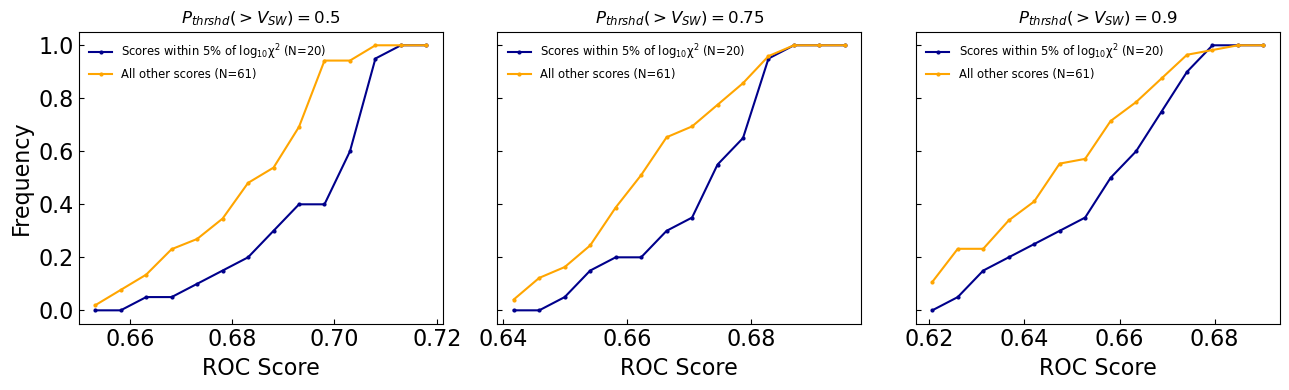

In [240]:
probability_thresholds = [0.5,0.75,0.9]
ensemble_size = 100

fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey=True, figsize = (13,4))
rank_hist = rank_histogram_grids[0]

for i, ax in enumerate(axes):

    score_grid = ROC_grids[i]
    scores_within_bounds_BS, scores_out_bounds_BS = separate_score_populations(rank_hist=rank_hist, brier_grid=score_grid)

    bins = np.linspace(np.min(scores_within_bounds_BS)-0.01,np.max(scores_out_bounds_BS)+0.01,15)

    ### Computing CDF for briers scores within/without briers minima bounds
    hist_1, bin_edges_1 = np.histogram(scores_within_bounds_BS, bins = bins, normed = True)
    dx1 = bin_edges_1[1] - bin_edges_1[0]
    F1 = np.cumsum(hist_1)*dx1

    hist_2, bin_edges_2 = np.histogram(scores_out_bounds_BS, bins = bins, normed = True)
    dx2 = bin_edges_2[1] - bin_edges_2[0]
    F2 = np.cumsum(hist_2)*dx2

    hist_tot, bin_edges_tot = np.histogram(briers_grids[0], bins = bins, normed = True)
    dx_tot = bin_edges_tot[1] - bin_edges_tot[0]
    Ftot = np.cumsum(hist_tot)*dx_tot

    ax.plot(bin_edges_1[1:], F1, marker = 'o', markersize = 2, label = f'Scores within 5% of $\mathrm{{\log_{{10}}{{\chi^2}}}}$ (N={len(scores_within_bounds_BS)})', color = 'darkblue')
    ax.plot(bin_edges_2[1:], F2, marker = 'o', markersize = 2, label = f'All other scores (N={len(scores_out_bounds_BS)})', color = 'orange')

    ax.set_title(f'$P_{{thrshd}}(>V_{{SW}})={probability_thresholds[i]}$')
    ax.tick_params(direction = 'in')
    ax.legend(frameon = False, fontsize = 'small', loc = 'upper left')
    ax.set_xlabel(f'ROC Score')

axes[0].set_ylabel('Frequency')
plt.tight_layout()
#plt.xlim(0.12, 0.25)

fname = 'ROC_CDF_solar_min.svg'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_03\\{fname}'
plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

In [131]:
def generate_recurrence(CR_chunk, omni_data):

    forecast_window = 27.2753*u.day
    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:

        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(forecast_window.value, unit = 'days')
        data_chunks.append(omni_data.loc[CR_start:CR_end])

    # combining data frames into single frame
    combined_data = pd.concat(data_chunks)

    ## Define carrington rotation offset for index
    carrington_rotation = pd.Timedelta(27.25, unit = 'days')
    omni_data_reccurance = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

    # Isolate data within forecast range + backward additional month needed for 1st carrington rotations of forecast
    omni_data_reccurance = omni_data_reccurance.loc[(combined_data.index[0]-carrington_rotation):(combined_data.index[-1])]

    # Grab index from isolated reccurence data set (combined_data index) 
    omni_data_index = omni_data_reccurance.index

    # Project index forward by 1 carrington rotation
    reccurance_forecast_index = omni_data_index + carrington_rotation

    # Set index for reccurent forecast to the new forward projected datetime series
    reccurance_forecast = omni_data_reccurance.set_index(reccurance_forecast_index)
    reccurance_forecast = reccurance_forecast.loc[pd.to_datetime(combined_data.index[0]):pd.to_datetime(combined_data.index[-1])]

    return reccurance_forecast, omni_data.loc[(combined_data.index[0]):combined_data.index[-1]]

def ICMElist(filepath = None):
    # -*- coding: utf-8 -*-
    """
    A script to read and process Ian Richardson's ICME list.

    Some pre-processing is required:
        Download the following webpage as a html file: 
            http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm
        Open in Excel, remove the year rows, delete last column (S) which is empty
        Cut out the data table only (delete header and footer)
        Save as a CSV.

    """
    
    if filepath is None:
        datapath =  system._setup_dirs_()['datapath']
        filepath = os.path.join(datapath,
                                'Richardson_Cane_Porcessed_ICME_list.csv')
    
    
    icmes=pd.read_csv(filepath,header=None)
    #delete the first row
    icmes.drop(icmes.index[0], inplace=True)
    icmes.index = range(len(icmes))
    
    for rownum in range(0,len(icmes)):
        for colnum in range(0,3):
            #convert the three date stamps
            datestr=icmes[colnum][rownum]
            year=int(datestr[:4])
            month=int(datestr[5:7])
            day=int(datestr[8:10])
            hour=int(datestr[11:13])
            minute=int(datestr[13:15])
            #icmes.set_value(rownum,colnum,datetime(year,month, day,hour,minute,0))
            icmes.at[rownum,colnum] = datetime.datetime(year,month, day,hour,minute,0)
            
        #tidy up the plasma properties
        for paramno in range(10,17):
            dv=str(icmes[paramno][rownum])
            if dv == '...' or dv == 'dg' or dv == 'nan':
                #icmes.set_value(rownum,paramno,np.nan)
                icmes.at[rownum,paramno] = np.nan
            else:
                #remove any remaining non-numeric characters
                dv=re.sub('[^0-9]','', dv)
                #icmes.set_value(rownum,paramno,float(dv))
                icmes.at[rownum,paramno] = float(dv)
        
    
    #chage teh column headings
    icmes=icmes.rename(columns = {0:'Shock_time',
                                  1:'ICME_start',
                                  2:'ICME_end',
                                  10:'dV',
                                  11: 'V_mean',
                                  12:'V_max',
                                  13:'Bmag',
                                  14:'MCflag',
                                  15:'Dst',
                                  16:'V_transit'})
    return icmes

In [38]:
recurrance_chunks = []
era_data_chunks = []

for CR_chunk in solar_min_list:
    rec_forecast, data_chunk = generate_recurrence(CR_chunk=CR_chunk, omni_data=omni_data)
    recurrance_chunks.append(rec_forecast)
    era_data_chunks.append(data_chunk)

recurrance_forecast = pd.concat(recurrance_chunks)
solar_min_data = pd.concat(era_data_chunks)


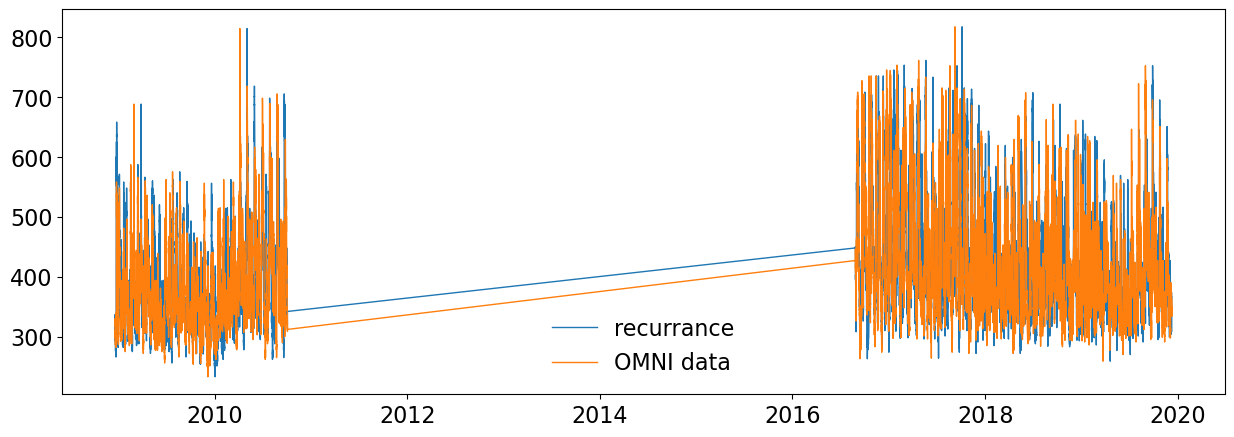

In [39]:
plt.figure(figsize=(15,5))
plt.plot(recurrance_forecast['V'], lw = 1, label = 'recurrance')
plt.plot(solar_min_data['V'], lw = 1, label = 'OMNI data')
plt.legend(frameon = False)
plt.show()

In [173]:
df_ICME = ICMElist("C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\Richardson_Cane_Porcessed_ICME_list.csv")
df_ICME = df_ICME.set_index('Shock_time')

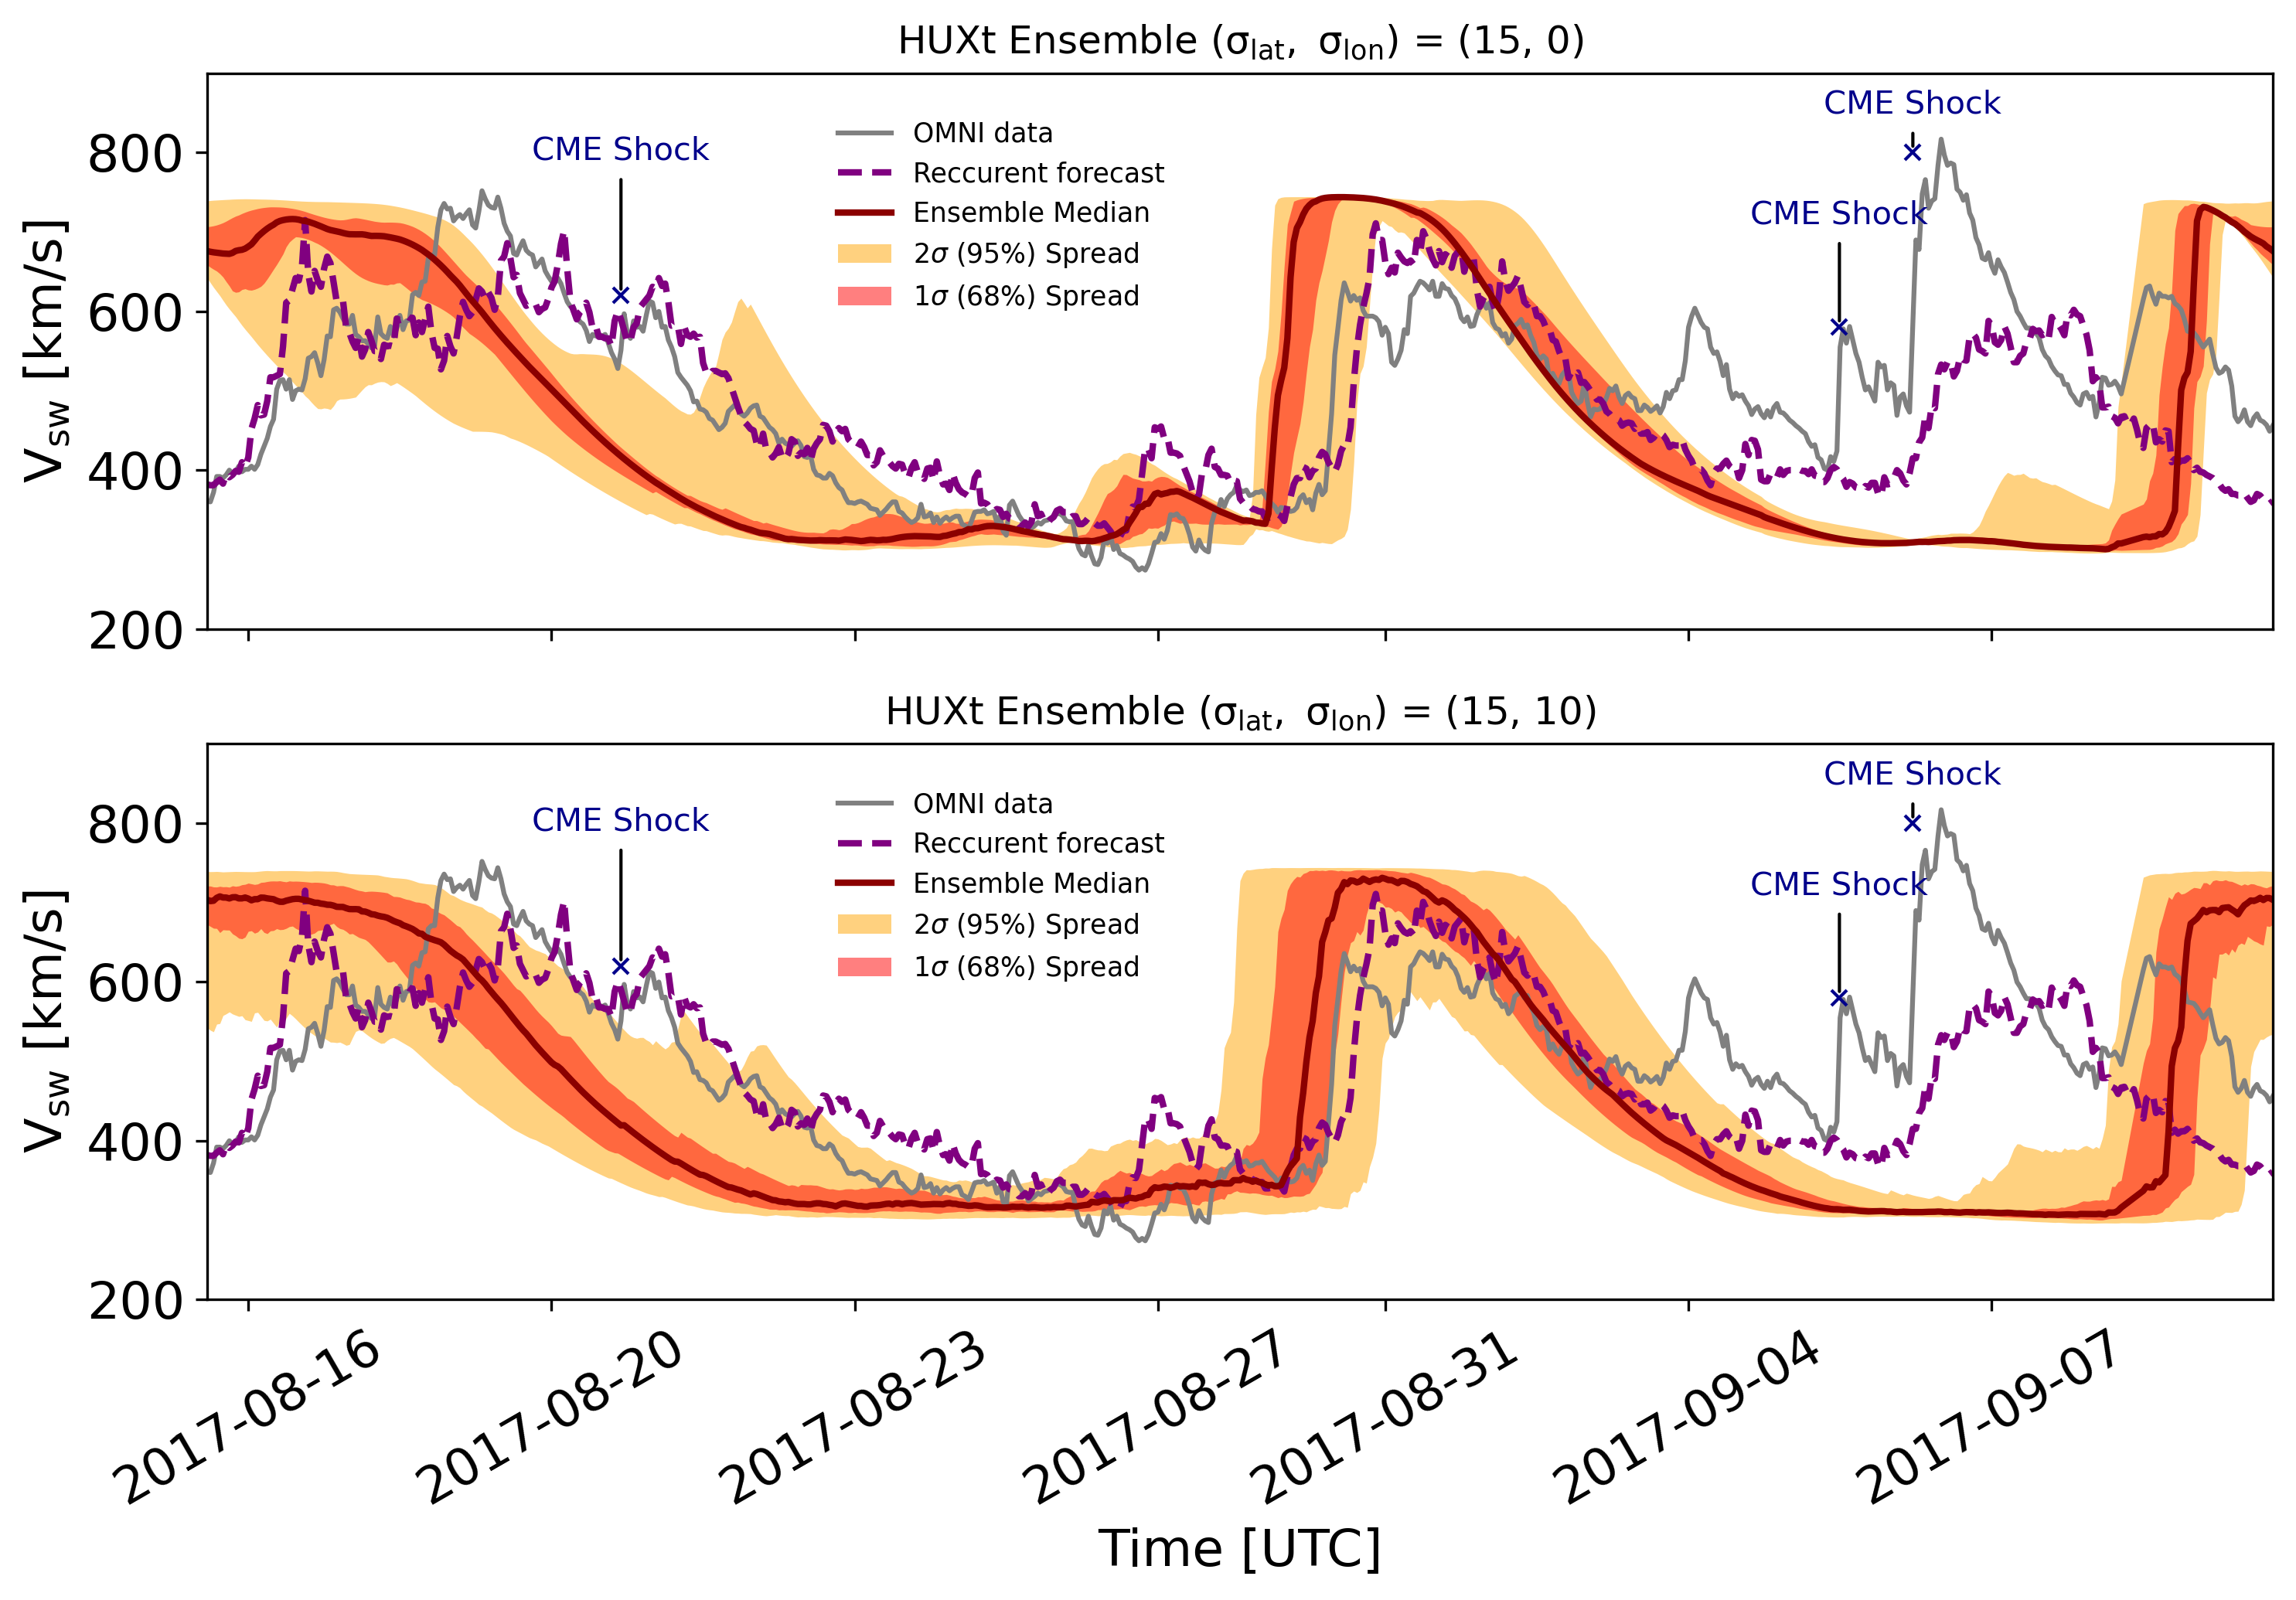

In [238]:
lat_dev = 15
long_dev = 0
ensemble_size = 100
CR_chunk = [2194]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

CME_list = df_ICME.loc[observed_data.index[0]:observed_data.index[-1]].reset_index()


lp_lat_dev = 15
lp_long_dev = 10
lp_ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lp_lat_dev, long_pert_var=lp_long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)

recurrence_for_vis = recurrance_forecast.loc[observed_data.index[0]:observed_data.index[-1]]

speed_lower_1sig = np.percentile(ensemble_members, 34.1, axis = 0)
speed_upper_1sig = np.percentile(ensemble_members, 100-34.1, axis = 0)

lp_speed_lower_1sig = np.percentile(lp_ensemble_members, 34.1, axis = 0)
lp_speed_upper_1sig = np.percentile(lp_ensemble_members, 100-34.1, axis = 0)

speed_lower_2sig = np.percentile(ensemble_members, 13.6, axis = 0)
speed_upper_2sig = np.percentile(ensemble_members, 100-13.6, axis = 0)

lp_speed_lower_2sig = np.percentile(lp_ensemble_members, 13.6, axis = 0)
lp_speed_upper_2sig = np.percentile(lp_ensemble_members, 100-13.6, axis = 0)

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,7), dpi = 300, sharex=True)

axes[0].fill_between(ensemble_members[0].index, y1 = speed_lower_2sig, y2 = speed_upper_2sig, label = r'2$\sigma$ (95%) Spread', color = 'orange', alpha = 0.5, lw = 0)
axes[0].fill_between(ensemble_members[0].index, y1 = speed_lower_1sig, y2 = speed_upper_1sig, label = r'1$\sigma$ (68%) Spread', color = 'red', alpha = 0.5, lw = 0)


axes[0].plot(omni_data['V'][ensemble_members[0].index[0]:ensemble_members[0].index[-1]], color = 'grey', lw = 1.5, label = 'OMNI data')
axes[0].plot(recurrence_for_vis['V'], color = 'purple', linestyle = '--', label = 'Reccurent forecast', lw = 2)
axes[0].plot(ensemble_members[0].index, np.median(ensemble_members,axis=0), color = 'darkred', lw = 2, label = 'Ensemble Median')
axes[0].set_title(f'HUXt Ensemble ($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev}, {long_dev})')
axes[0].set_ylabel(r'$\mathrm{V_{sw}}$ [km/s]')
axes[0].legend(frameon = False, fontsize = 'small', loc = (0.3,0.55))
axes[0].set_ylim(200,900)

axes[1].fill_between(ensemble_members[0].index, y1 = lp_speed_lower_2sig, y2 = lp_speed_upper_2sig, label = r'2$\sigma$ (95%) Spread', color = 'orange', alpha = 0.5, lw = 0)
axes[1].fill_between(lp_ensemble_members[0].index, y1 = lp_speed_lower_1sig, y2 = lp_speed_upper_1sig, label = '1$\sigma$ (68%) Spread', color = 'red', alpha = 0.5, lw = 0)

axes[1].plot(omni_data['V'][ensemble_members[0].index[0]:ensemble_members[0].index[-1]], color = 'grey', lw = 1.5, label = 'OMNI data')
axes[1].plot(recurrence_for_vis['V'], color = 'purple', linestyle = '--', label = 'Reccurent forecast', lw = 2)
axes[1].plot(lp_ensemble_members[0].index, np.median(lp_ensemble_members,axis=0), color = 'darkred', lw = 2, label = 'Ensemble Median')
axes[1].set_title(f'HUXt Ensemble ($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lp_lat_dev}, {lp_long_dev})')
axes[1].set_xlabel('Time [UTC]')
axes[1].set_ylabel(r'$\mathrm{V_{sw}}$ [km/s]')
axes[1].set_xticklabels(ensemble_members[0].index[::90].strftime("%Y-%m-%d"), rotation = 30)
axes[1].legend(frameon = False, fontsize = 'small', loc = (0.3,0.55))
axes[1].set_xlim(ensemble_members[0].index[0],ensemble_members[0].index[-1])
axes[1].set_ylim(200,900)

xy_pos = [40,30,10]
for i in range(len(CME_list)):
    axes[0].annotate('CME Shock', xy=(CME_list.iloc[i]['Shock_time'], CME_list.iloc[i]['V_max']), xytext=(0, xy_pos[i]), textcoords='offset points', 
    arrowprops=dict(arrowstyle="-"), ha='center', va='bottom', color = 'darkblue')
    axes[1].annotate('CME Shock', xy=(CME_list.iloc[i]['Shock_time'], CME_list.iloc[i]['V_max']), xytext=(0, xy_pos[i]), textcoords='offset points', 
    arrowprops=dict(arrowstyle="-"), ha='center', va='bottom', color = 'darkblue')

axes[0].plot(CME_list['Shock_time'], CME_list['V_max'], marker = 'x', markersize = 5, color = 'darkblue', linestyle = '')
axes[1].plot(CME_list['Shock_time'], CME_list['V_max'], marker = 'x', markersize = 5, color = 'darkblue', linestyle = '')


fname = 'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_03\\perturbation_impact.svg'
plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')

plt.tight_layout()
plt.show()

In [41]:
# Enesmble data parameters
key = 'min'
lat_dev = 20
long_dev = 15
ensemble_size = 100

# Compute calibration curve for best parameters at solar min
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)



In [42]:
# Read in deterministic HUXt output
key = 'min'
CR_chunk = solar_era_dict[key]

deterministic_HUXt_ouput_list = [read_deterministic_forecast_cdf(cr) for cr in CR_chunk]
data_chunks = get_data_chunks_per_CR(CR_chunk=CR_chunk, omni_data = omni_data)

# Resample deterministic forecast onto omni data timestep
resampled_deterministic_output = []
for i, df in enumerate(deterministic_HUXt_ouput_list):

    df_ = df.set_index('datetime')
    resampled_forecast = eef.interpolate_and_resample(observed_data_index = data_chunks[i].index, forecast_index=df_.index, forecast=df_['vsw'])
    resampled_deterministic_output.append(resampled_forecast)

# Create single timeseries dataframe with datetime index from omni 
deterministic_forecast = np.concatenate(resampled_deterministic_output)
deterministic_forecast = pd.DataFrame({'vsw': deterministic_forecast}, index = observed_data.index)

In [46]:
roc_curve_prob = eef.generate_roc_curve_from_ensemble(ensemble_members=ensemble_members, observed_data=observed_data['V'], threshold_range=(200,700), threshold_num=10, probability_threshold=0.5)
roc_curve_recurrence = eef.generate_roc_curve(forecast=recurrance_forecast['V'].to_numpy(), observed_data=solar_min_data['V'], threshold_range=(200,700), threshold_num=10)
roc_curve_det = eef.generate_roc_curve(forecast=deterministic_forecast['vsw'].to_numpy(), observed_data=observed_data['V'], threshold_range=(200,700), threshold_num=10)


ROC_score_rec = compute_roc_score(roc_curve=roc_curve_recurrence)
ROC_score_prob = compute_roc_score(roc_curve=roc_curve_prob)
ROC_score_det = compute_roc_score(roc_curve=roc_curve_det)
BS_rec = eef.compute_brier_score(forecast=recurrance_forecast['V'], observed_data=solar_min_data['V'], threshold=500)



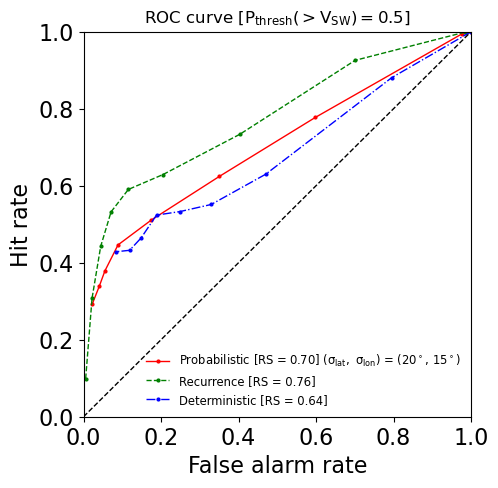

In [106]:
rc_hit_rate, rc_false_alarm_rate = zip(*roc_curve_prob)
rc_hit_rate_rec, rc_false_alarm_rate_rec = zip(*roc_curve_recurrence)
rc_hit_rate_det, rc_false_alarm_rate_det = zip(*roc_curve_det)

plt.figure(dpi=100, figsize=(5,5))

plt.plot(rc_false_alarm_rate, rc_hit_rate, marker = 'o', markersize = 2, linewidth = 1, 
         label = f'Probabilistic [RS = {ROC_score_prob:.2f}] ($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev}$^\circ$, {long_dev}$^\circ$)', 
         color = 'red')

plt.plot(rc_false_alarm_rate_rec, rc_hit_rate_rec, marker = 'o', markersize = 2, linewidth = 1, label = f'Recurrence [RS = {ROC_score_rec:.2f}]', 
         color = 'green', linestyle = '--')

plt.plot(rc_false_alarm_rate_det, rc_hit_rate_det, marker = 'o', markersize = 2, linewidth = 1, label = f'Deterministic [RS = {ROC_score_det:.2f}]', 
         color = 'blue', linestyle = '-.')

plt.plot([0,1], [0,1], linestyle = '--', lw = 1, color = 'black')
plt.title(f'ROC curve [$\mathrm{{P_{{thresh}}(>V_{{SW}})}}={0.5}]$')
plt.xlabel('False alarm rate')
plt.ylabel('Hit rate')
plt.legend(frameon = False, fontsize = 'small', loc = 'lower right')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


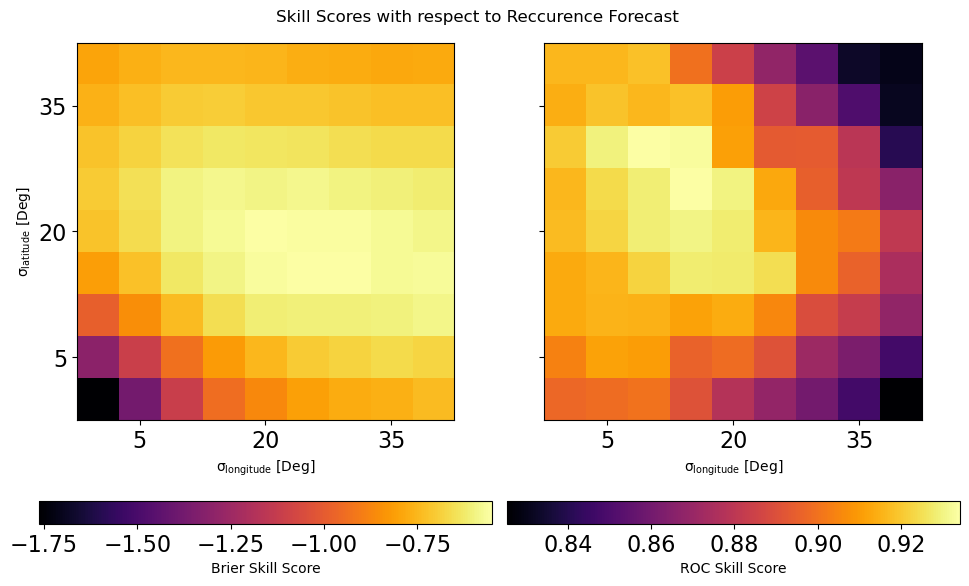

In [74]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (10,6))

axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

im1 = axes[0].imshow((1-briers_grids[0]/BS_rec), cmap='inferno', origin = 'lower') 
im2 = axes[1].imshow((ROC_grids[0]/ROC_score_rec), cmap='inferno', origin = 'lower') 

fig.suptitle('Skill Scores with respect to Reccurence Forecast')
axes[0].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[0].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
axes[0].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = [0,1]

for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar1 = fig.colorbar(im1, ax=axes[0], pad=0.15, orientation = 'horizontal', aspect = 20) #, anchor = (-2,-2), aspect = 30)  
cbar1.set_label(f'Brier Skill Score', fontsize = 'medium')

cbar2 = fig.colorbar(im2, ax=axes[1], pad=0.15, orientation = 'horizontal', aspect = 20) #, anchor = (-2,-2), aspect = 30)  
cbar2.set_label(f'ROC Skill Score', fontsize = 'medium')

plt.tight_layout()

# fname = 'Briers_ROC_grids_solar_min.svg'
# path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_01\\{fname}'
# plt.savefig(path, format = 'svg', dpi = 300,bbox_inches='tight')

plt.show()

### Cost Loss

In [108]:
# Enesmble data parameters
key = 'min'
lat_dev = 20
long_dev = 15
ensemble_size = 100

# Compute calibration curve for best parameters at solar min
CR_chunk = solar_era_dict[key]
ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_chunk, lat_dev=lat_dev, long_pert_var=long_dev, 
                                                                omni_data = omni_data, ensemble_size=ensemble_size)


In [109]:
# Read in deterministic HUXt output
key = 'min'
CR_chunk = solar_era_dict[key]

deterministic_HUXt_ouput_list = [read_deterministic_forecast_cdf(cr) for cr in CR_chunk]
data_chunks = get_data_chunks_per_CR(CR_chunk=CR_chunk, omni_data = omni_data)

# Resample deterministic forecast onto omni data timestep
resampled_deterministic_output = []
for i, df in enumerate(deterministic_HUXt_ouput_list):

    df_ = df.set_index('datetime')
    resampled_forecast = eef.interpolate_and_resample(observed_data_index = data_chunks[i].index, forecast_index=df_.index, forecast=df_['vsw'])
    resampled_deterministic_output.append(resampled_forecast)

# Create single timeseries dataframe with datetime index from omni 
deterministic_forecast = np.concatenate(resampled_deterministic_output)
deterministic_forecast = pd.DataFrame({'vsw': deterministic_forecast}, index = observed_data.index)

In [110]:
def finding_cost_loss(actual_events, forecasted_probabilities, threshold):
    """
    Finding costs and loss based on an action threshold.

    Parameters:
    actual_events (boolean array): List of actual events (True for event occurred, False otherwise).
    forecasted_probabilities (array): List of forecasted probabilities for events.
    threshold (float): Threshold for action.

    Returns:
    dict: Dictionary containing counts for correct forecasts, incorrect forecasts, and missed events.
    """
    correct_forecasts = 0
    incorrect_forecasts = 0
    missed_events = 0

    for actual, probability in zip(actual_events, forecasted_probabilities):
        if actual and probability >= threshold: # correctly forecast event (incurring a cost)
            correct_forecasts += 1
        elif not actual and probability >= threshold: # incoreectly forecast event (incurring a cost)
            incorrect_forecasts += 1
        elif actual and probability < threshold: # missing an event (incurring a loss)
            missed_events += 1
    
    return {'correct_costs': correct_forecasts, 'incorrect_costs': incorrect_forecasts, 'loss': missed_events}


def calculate_potential_economic_value(actual_events, costs, losses, cost_loss_ratio):

    """
    Finding potenial economic value

    Parameters:
    actual_events (boolean array): List of actual events (True for event occurred, False otherwise).
    costs (float): number of costs
    losses (float): number of losses
    cost_loss_ratio (float): cost loss ratio for computing potential economic value

    Returns:
    V: potential economic value
    """
        
    climatology_prob = np.mean(actual_events)
    #climatology_prob = 0.25
    perfect_cost = np.sum(actual_events)

    # climatological cost changes if climatological prob is above/below c/l ratio 
    if cost_loss_ratio <= climatology_prob: # always take action

        climatological_cost = len(actual_events)
        climatological_expense = climatological_cost*cost_loss_ratio
    
        #climatological_expense = len(action_threshold_data)*cost_loss_ratio

    elif cost_loss_ratio > climatology_prob: # never take action

        climatological_loss = perfect_cost
        climatological_expense = climatological_loss

    # forecast expense
    forecast_expense = costs*cost_loss_ratio + losses

    # potential economic value
    V = 100 * ((climatological_expense - forecast_expense)/(climatological_expense - perfect_cost*cost_loss_ratio))

    return V



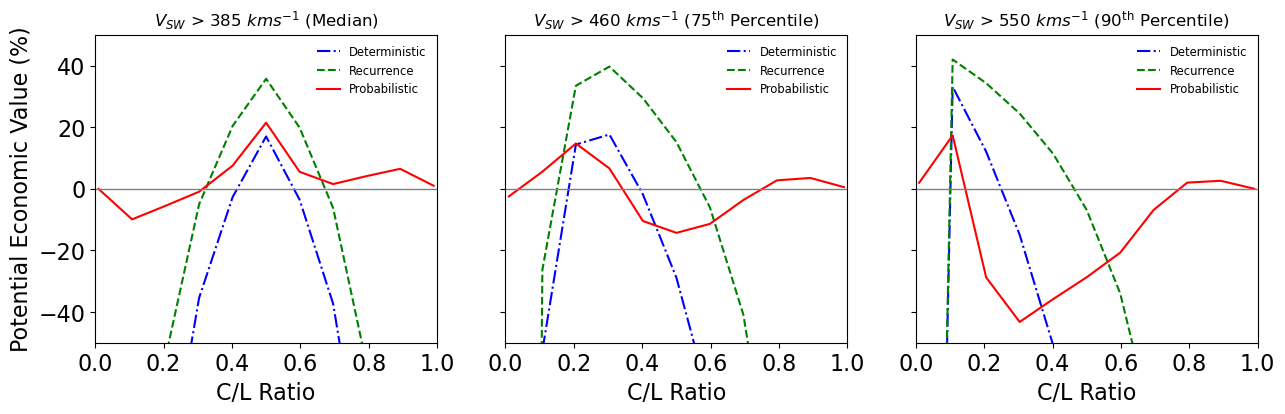

In [116]:
# Define cost/loss bins
cost_loss_ratios = np.linspace(0.01,0.99,11)

# Action thresholds for cost/loss
action_thresholds = [385, 460, 550]
threshold_key = ['Median', r'$\mathrm{75^{th}}$ Percentile', r'$\mathrm{90^{th}}$ Percentile'] # plotting labels

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharey = True)

for i, action_threshold in enumerate(action_thresholds):

    # generate probabilistic forecast from ensemble and binarise based on action threshold
    probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, threshold=action_threshold, ensemble_size=ensemble_size)
    action_threshold_data = observed_data['V'] > action_threshold

    # initalise lists to store Potential Economic Values across the cost/loss ratio bins 
    PEV_list = []
    PEV_list_det = []
    PEV_list_rec = []

    # generate the cost/loss (true positives, false positives, missed events) dictionaries for the deterministic and recurrence forecasts for comparison to ensmeble
    deterministic_cost_loss = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=deterministic_forecast['vsw'] > action_threshold, threshold=1)
    recurrence_cost_loss = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=recurrance_forecast['V'] > action_threshold, threshold=1)

    # loop through cost/loss ratios
    for cl in cost_loss_ratios:
        
        # set cl ratio as probability threshold
        prob_thresh = cl

        # Compute the costs and losses for ensemble probabilistic forecast with new cl ratio
        ensemble_cost_loss_dict = finding_cost_loss(actual_events=action_threshold_data, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
        PEV_list.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                    losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
        
        # Compute PEV for deterministic and recurrence forecasts
        PEV_list_det.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = deterministic_cost_loss['correct_costs'] + deterministic_cost_loss['incorrect_costs'],
                                    losses = deterministic_cost_loss['loss'], cost_loss_ratio = cl))
        PEV_list_rec.append(calculate_potential_economic_value(actual_events=action_threshold_data, costs = recurrence_cost_loss['correct_costs'] + recurrence_cost_loss['incorrect_costs'],
                                    losses = recurrence_cost_loss['loss'], cost_loss_ratio = cl))

    #plot results
    axes[i].plot(cost_loss_ratios, PEV_list_det, label = 'Deterministic', color = 'blue', linestyle = '-.')
    axes[i].plot(cost_loss_ratios, PEV_list_rec, label = 'Recurrence', color = 'green', linestyle = '--')
    axes[i].plot(cost_loss_ratios, PEV_list, label = 'Probabilistic', color = 'red')

    axes[i].set_xlabel('C/L Ratio')
    
    axes[i].set_title(f'$V_{{SW}}$ > {action_threshold} $kms^{{-1}}$ ({threshold_key[i]})')
    axes[i].legend(frameon = False, fontsize = 'small')
    axes[i].axhline(0, lw = 1, color = 'grey')
    axes[i].set_ylim(-50,50)
    axes[i].set_xlim(0,1)

axes[0].set_ylabel('Potential Economic Value (%)')
plt.show()

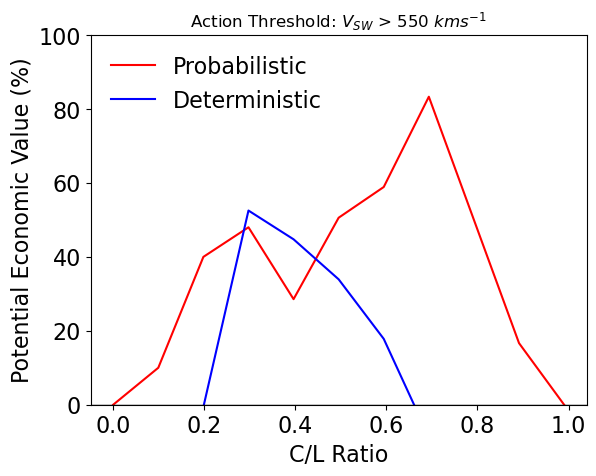

In [68]:
cost_loss_ratios = np.linspace(0.001,0.99,11)
action_threshold = 550
#prob_thresh = 0.5 

observations = np.array([0,    1,    1,    0,    0,   0,    1,   0,   0,    0,    0,   0,    1,    0,    1,    1])
deterministic_forecast = np.array([0,    0,    1,    1,    0,   0,    1,   0,   0,    1,    0,   0,    0,    0,    1,    1])
probabilistic_forecast = np.array([0.59, 0.21, 0.89, 0.69, 0.4, 0.19, 0.9, 0.4, 0.19, 0.29, 0.4, 0.09, 0.89, 0.19, 0.79, 0.71])

ensemble_cost_loss_dict_det = finding_cost_loss(actual_events=observations, forecasted_probabilities=deterministic_forecast, threshold = 1)

PEV_list = []
PEV_list_det = []

for cl in cost_loss_ratios:
    
    
    prob_thresh = cl

    ensemble_cost_loss_dict = finding_cost_loss(actual_events=observations, forecasted_probabilities=probabilistic_forecast, threshold = prob_thresh)
    PEV_list.append(calculate_potential_economic_value(actual_events=observations, costs = ensemble_cost_loss_dict['correct_costs'] + ensemble_cost_loss_dict['incorrect_costs'],
                                   losses = ensemble_cost_loss_dict['loss'], cost_loss_ratio = cl))
    PEV_list_det.append(calculate_potential_economic_value(actual_events=observations, costs = ensemble_cost_loss_dict_det['correct_costs'] + ensemble_cost_loss_dict_det['incorrect_costs'],
                                   losses = ensemble_cost_loss_dict_det['loss'], cost_loss_ratio = cl))


#plt.figure(dpi=300)
plt.plot(cost_loss_ratios, PEV_list, label = 'Probabilistic', color = 'red')
plt.plot(cost_loss_ratios, PEV_list_det, label = 'Deterministic', color = 'blue')

plt.xlabel('C/L Ratio')
plt.ylabel('Potential Economic Value (%)')
plt.title(f'Action Threshold: $V_{{SW}}$ > {action_threshold} $kms^{{-1}}$')
plt.legend(frameon = False)
plt.axhline(0, lw = 1, color = 'black')
plt.ylim(0,100)

plt.show()


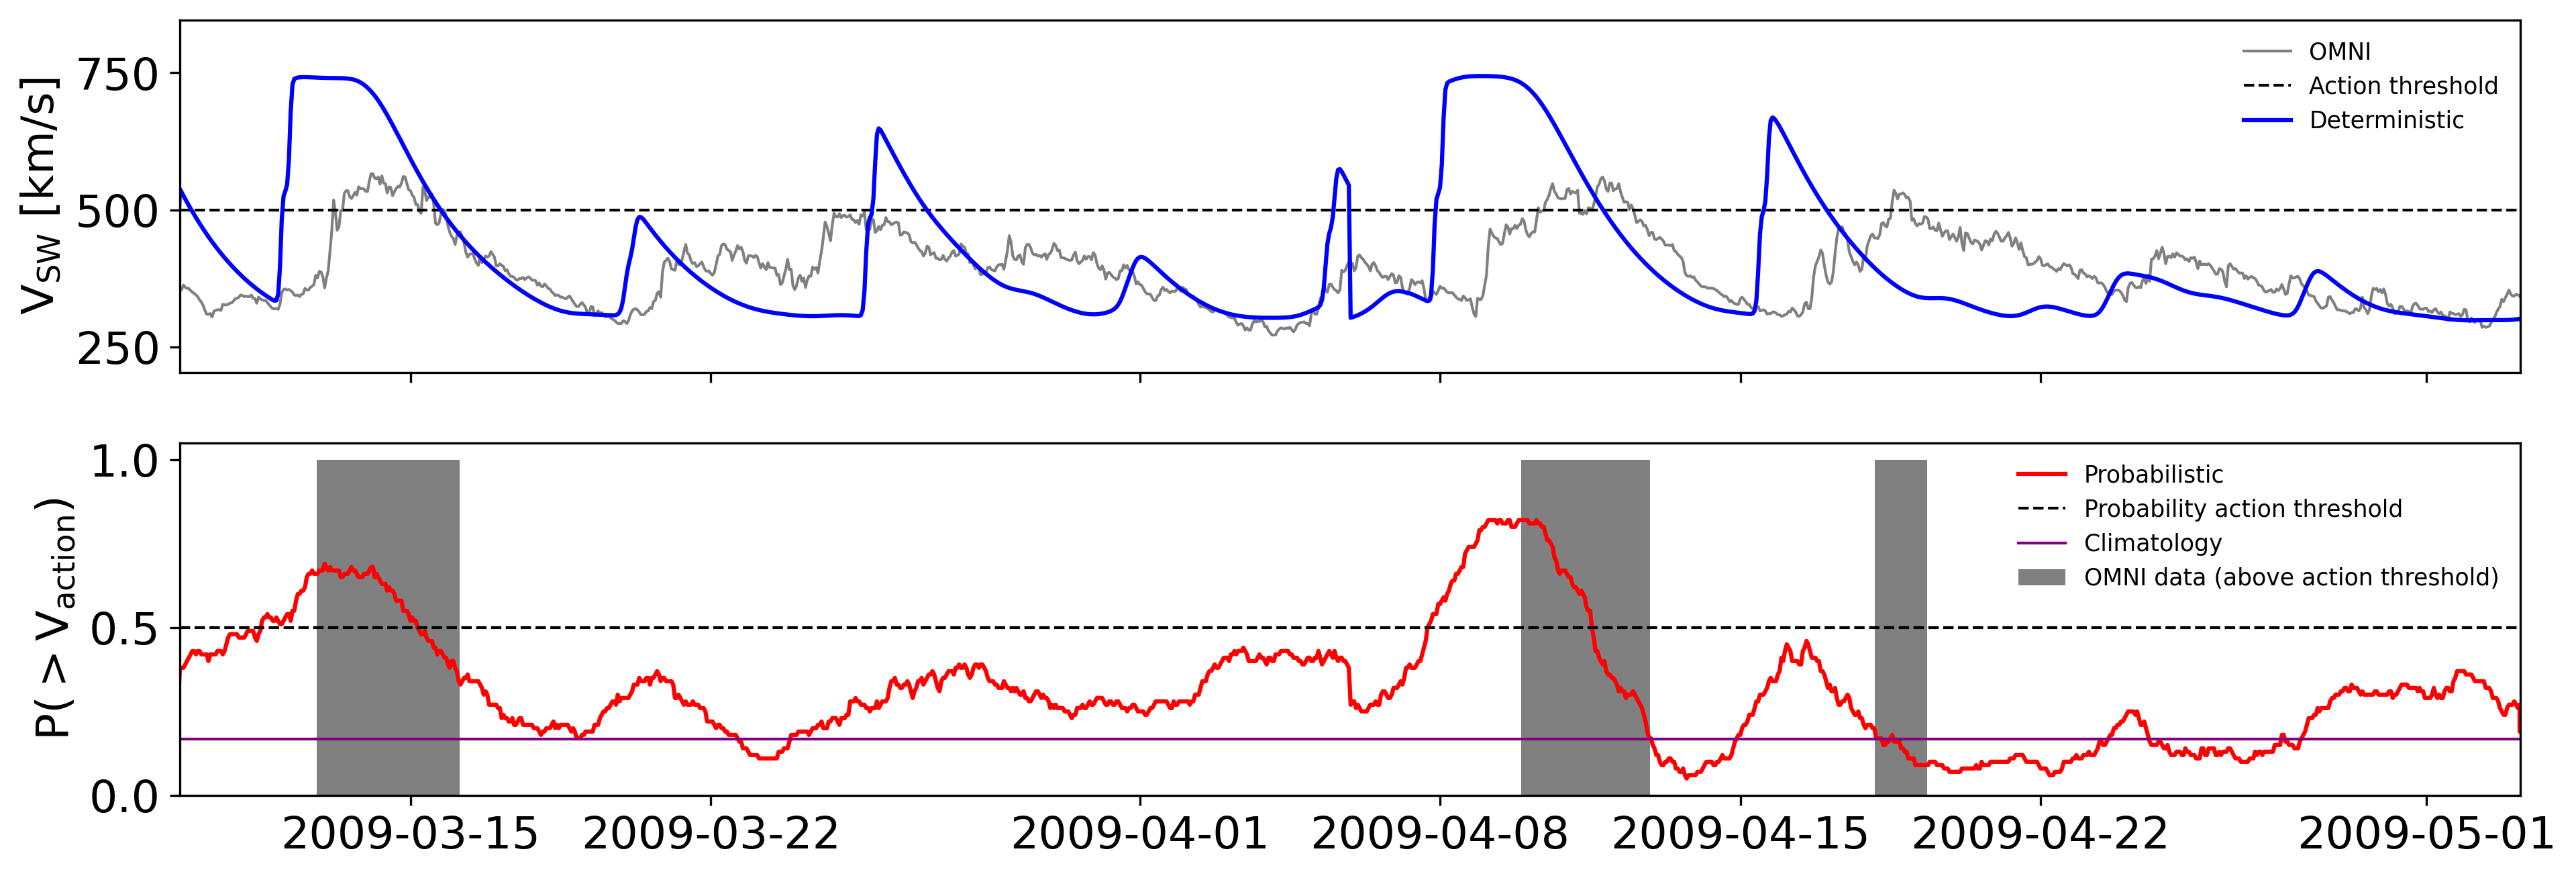

In [51]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize = (15,5), dpi = 300, sharex = True)

forecast_window = 27.2753*u.day
CR = 2081
CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
CR_end = CR_start + pd.Timedelta((forecast_window*2).value, unit = 'days')

axes[0].plot(observed_data['V'], lw = 1, color = 'grey', label = 'OMNI')
axes[0].axhline(action_threshold, lw = 1, linestyle = '--', color = 'black', label = 'Action threshold')
axes[0].plot(deterministic_forecast['vsw'], color = 'blue', label = 'Deterministic')
axes[0].set_ylabel(r'$\mathrm{V_{SW}}$ [km/s]')
axes[1].set_ylabel(r'$\mathrm{P(>V_{action})}$')


axes[1].bar(action_threshold_data.index, action_threshold_data.to_numpy(), color = 'grey', label = 'OMNI data (above action threshold)')
axes[1].plot(observed_data.index, probabilistic_forecast, color = 'red', label = 'Probabilistic')
axes[1].axhline(0.5, linestyle = '--', lw = 1, color = 'black', label = 'Probability action threshold')
axes[1].axhline(np.mean(action_threshold_data.to_numpy()), lw = 1, color = 'purple', label = 'Climatology')
axes[0].legend(frameon = False, fontsize = 'small')
axes[1].legend(frameon = False, fontsize = 'small')

plt.xlim(CR_start, CR_end)


plt.show()
